In [87]:
#import feature_attribution_testing
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

from utils.data import load_datasets, load_datasets_reduced
from utils.models import load_model
from utils import xplain
from explain import load_explainer

from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat, EpsilonPlus, EpsilonAlpha2Beta1
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient
from zennit.image import imgify

from torch.utils.data import Dataset
from torchvision import transforms
import torchvision

from PIL import Image
from skimage import feature

torch.cuda.is_available()

False

# Design of Experiments
### 1. Show that LRP and DuaLRP disagree (qualitatively + quantatively (e.g. by calculating the variance))
### 2. Pixelflipping: Take most important training point, use DuaLRP to calculate most importan pixels. Flip most important pixels in the test (or train) point, then reexplain. The attribution for the training point should drop quicker than when flipping random pixels.
### 2b. If we flip pixels of the test point, we can also compare it to LRP and see how quickly the attribution changes (to prove that DuaLRP is more connected to attribution than LRP)
### 3. Create artificial joint superclasses (e.g. even numbers in MNIST) and see how the DuaLRP is different for elements of the same class (explaining a 2 with a 2) and elements of the same superclass but different class (explaining a 2 with an 8)
### 3b. If we glue datapoints together (e.g. containing a 2 and a 8) and aim to identify even numbers, in DuaLRP when comapring to a 2 as training point, the 2 in the test should light up; same for the 8
### 4. Non artificial, but useful example, where test point gets misclassified (e.g. antilope because the horns are straight and are mistaken for giraffe legs). Then looking at giraffe training points with DuaLRP helps us identify that it's indeed the legs that cause the mistake

# Utils

In [99]:
def upscale(img,factor=4):
    newimg=torch.zeros((factor*img.shape[0],factor*img.shape[1],3))
    for i in range(28):
        for j in range(28):
                newimg[i*factor:(i+1)*factor,j*factor:(j+1)*factor]=img[i,j]
    return newimg

def evaluate_sample(model, train, t):
    probs = torch.nn.functional.softmax(model(train.transform(t.numpy()).unsqueeze(dim=0))[0])
    return (probs.argmax().item(), probs.max().item())

def display_img(input, dataset):
    img = torch.clip(dataset.inverse_transform(input[0].clone().detach()), min=0., max=1.).squeeze()
    return img

def display_lrp(test_input, model, class_to_explain = None, composite = EpsilonPlus(), add_outline=True):
    num_classes = model.classifier.out_features

    if class_to_explain == None:
        class_to_explain = test_input[1]

    with Gradient(model=model, composite=composite) as attributor:
        out, relevance = attributor(test_input[0].unsqueeze(dim=0), torch.eye(num_classes)[[class_to_explain]])

    relevance = relevance[0].sum(0).detach().cpu()     

    img = imgify(relevance, cmap='bwr', symmetric = True)
        
    return img

def display_tda_lrp(train_input, test_input, train_idx, test_idx, xpl, model, mode = "train", class_to_explain = None, composite = EpsilonPlus(), add_outline=True):    

    if class_to_explain == None:
        class_to_explain = test_input[1]

    with torch.no_grad():
        train_features = model.features(train_input[0].unsqueeze(dim = 0))
        test_features = model.features(test_input[0].unsqueeze(dim = 0))
        attr_output = test_features * (xpl[test_idx, train_idx] / (train_features @ test_features.T)) if mode == "train" else train_features * (xpl[test_idx, train_idx] / (train_features @ test_features.T))

    to_attribute = train_input[0] if mode == "train" else test_input[0]

    with Gradient(model=model.features, composite=composite) as attributor:
        out, relevance = attributor(to_attribute.unsqueeze(dim=0), attr_output)

    relevance = relevance[0].sum(0).detach().cpu()

    img = imgify(relevance, cmap='bwr', symmetric = True)
    return img

def return_lrp(test_input, model, class_to_explain = None, composite = EpsilonPlus()):
    num_classes = model.classifier.out_features

    if class_to_explain == None:
        class_to_explain = test_input[1]

    with Gradient(model=model, composite=composite) as attributor:
        out, relevance = attributor(test_input[0].unsqueeze(dim=0), torch.eye(num_classes)[[class_to_explain]])

    relevance = relevance[0].sum(0).detach().cpu()

    return relevance

def return_tda_lrp(train_input, test_input, train_idx, test_idx, xpl, model, mode = "train", class_to_explain = None, composite = EpsilonPlus()):    

    if class_to_explain == None:
        class_to_explain = test_input[1]

    with torch.no_grad():
        train_features = model.features(train_input[0].unsqueeze(dim = 0))
        test_features = model.features(test_input[0].unsqueeze(dim = 0))
        attr_output = test_features * (xpl[test_idx, train_idx] / (train_features @ test_features.T)) if mode == "train" else train_features * (xpl[test_idx, train_idx] / (train_features @ test_features.T))

    to_attribute = train_input[0] if mode == "train" else test_input[0]

    with Gradient(model=model.features, composite=composite) as attributor:
        out, relevance = attributor(to_attribute.unsqueeze(dim=0), attr_output)

    relevance = relevance[0].sum(0).detach().cpu()

    return relevance

# Try different composites for ResNet??

# 1. Create Data Attribution, load dataset, load model

In [30]:
dataset = 'MNIST'
model = 'basic_conv'
xai_method = 'dualview'
#os.system(f"python explain.py --config_file ../config_files/explain/{dataset}/{model}_std_{xai_method}.yaml  ")

In [31]:
dualview_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_root = f"{dualview_root}/src/datasets"
class_groups = None
validation_size=2000
num_classes=10
device = "cpu"
dataset_name = "MNIST"
dataset_type = "std"
model_path = f"{dualview_root}/checkpoints/MNIST/std/MNIST_basic_conv_best"
model_name = "basic_conv"

In [32]:
ds_kwargs = {
    'data_root': data_root,
    'class_groups': class_groups,
    'num_classes': 10,
    'image_set': "test",
    'validation_size': validation_size,
    'only_train': False,
    'transform': None
}

train, test = load_datasets(dataset_name, dataset_type, **ds_kwargs)
mnist_model = load_model(model_name, dataset_name, num_classes).to(device)
checkpoint = torch.load(model_path, map_location=device)
mnist_model.load_state_dict(checkpoint["model_state"])
mnist_model.to(device)
mnist_model.eval()
print('\n')
print(mnist_model)

Validation ids:
tensor([7542, 8214, 3698,  ..., 7815, 7438, 3491])
Test ids:
tensor([5886,  911, 6853,  ..., 7126, 5089, 7716])


BasicConvModel(
  (features): Sequential(
    (conv-0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (relu-0): ReLU()
    (conv-1): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (relu-1): ReLU()
    (conv-2): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
    (relu-2): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc-0): Linear(in_features=2420, out_features=500, bias=True)
    (relu-3): ReLU()
    (fc-1): Linear(in_features=500, out_features=100, bias=True)
    (relu-4): ReLU()
  )
  (classifier): Linear(in_features=100, out_features=10, bias=True)
)


In [33]:
# load explanation
with torch.no_grad():
    xpl = torch.load('../explanations/MNIST/std/dualview_0.1/DualViewExplainer_00', map_location=torch.device('cpu'))
    print(xpl.shape)
    print(xpl[0].min(), xpl[0].argmin())
    print(xpl[0].max(), xpl[0].argmax())
    print(xpl[1].min(), xpl[1].argmin())
    print(xpl[1].max(), xpl[1].argmax())

torch.Size([200, 60000])
tensor(-15.2419) tensor(29588)
tensor(15.3034) tensor(28162)
tensor(-28.0288) tensor(45352)
tensor(36.4468) tensor(26709)


# 1b. Select uncertain training points

In [34]:
for i in range(1000):
    if i % 100 == 0:
        print(i)
    acc_array = np.empty(1000)
    inp = train[i]
    #inp_img = torch.clip(train.inverse_transform(inp[0].clone().detach()), min=0., max=1.).squeeze()
    inp_img = inp[0]
    acc = mnist_model(inp_img.unsqueeze(dim=0))[0][inp[1]]
    acc_array[i] = acc

acc_min_arg = np.argmin(acc_array)
acc_min_arg

0
100
200
300
400
500
600
700
800
900


296

In [35]:
mnist_model(train[acc_min_arg][0].unsqueeze(dim=0))[0]

tensor([ 20.2711, -16.7152,   0.9723,  -3.2547,  -9.8192,   5.7880,   2.1383,
         -7.0450,   1.9254,   0.7803], grad_fn=<SelectBackward0>)

# 2. Create classical LRP heatmap for (single) train and test sample

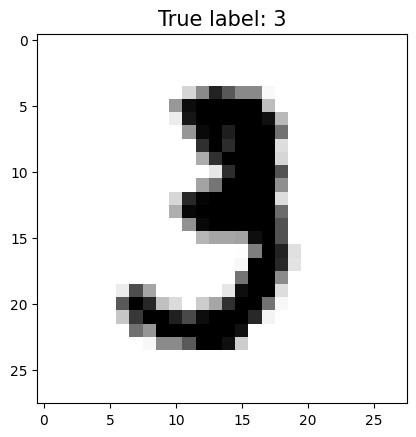

In [101]:
#train_idx = acc_min_arg
train_idx = 10
train_sample = train[train_idx]
img_train_sample = torch.clip(train.inverse_transform(train_sample[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {train_sample[1]}", fontsize=15)
plt.imshow(img_train_sample, cmap = "gray_r")
plt.show()

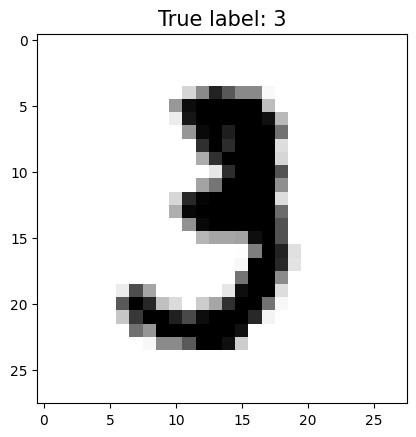

tensor(-0.4242) tensor(2.8088)


In [102]:
#train_idx = acc_min_arg
train_idx = 10
train_sample = train[train_idx]
img_train_sample = train_sample[0].clone().detach().squeeze()

plt.title(f"True label: {train_sample[1]}", fontsize=15)
plt.imshow(img_train_sample, cmap = "gray_r")
plt.show()
print(img_train_sample.min(), img_train_sample.max())

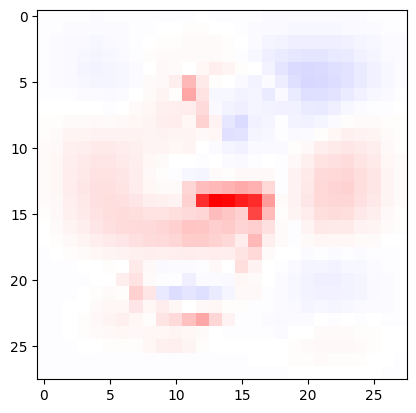

In [103]:
img = display_lrp(train_sample, mnist_model, composite=EpsilonPlus())
plt.imshow(img)
plt.show()

# Interlude: Find good composites for LRP for MNIST

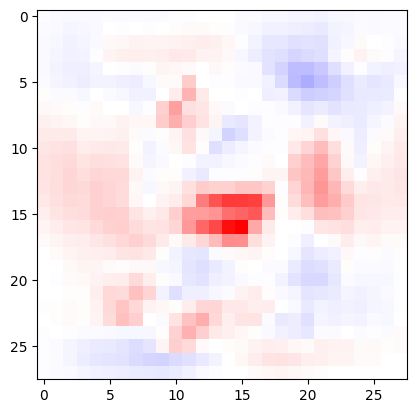

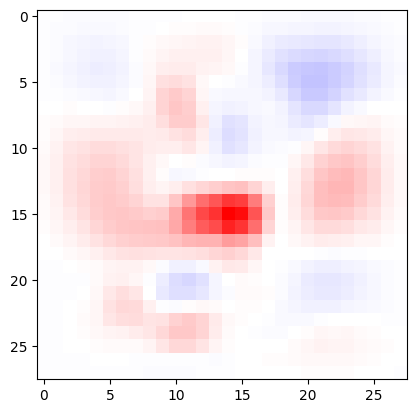

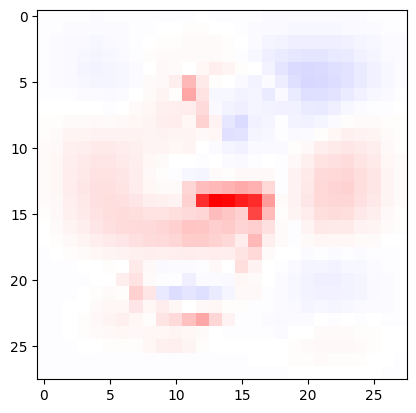

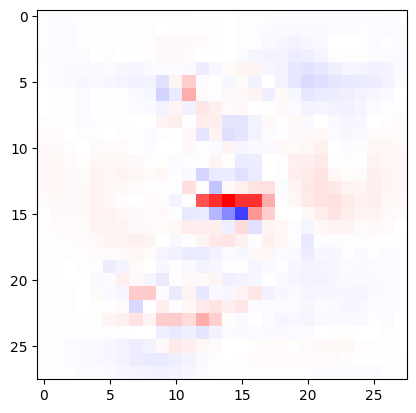

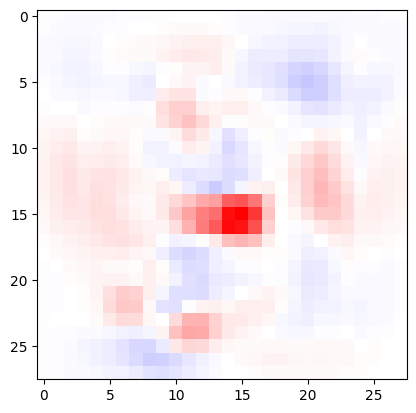

In [104]:
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat, EpsilonPlus, EpsilonAlpha2Beta1, EpsilonAlpha2Beta1Flat

sample_min, sample_max = train_sample[0].min(), train_sample[0].max()

for composite in [EpsilonGammaBox(low=sample_min, high=sample_max), EpsilonPlusFlat(), EpsilonPlus(), EpsilonAlpha2Beta1(), EpsilonAlpha2Beta1Flat()]:
    img = display_lrp(train_sample, mnist_model, composite=composite)
    plt.imshow(img)
    plt.show()



# 3. Create DualView-LRP heatmap for (single) train and test sample

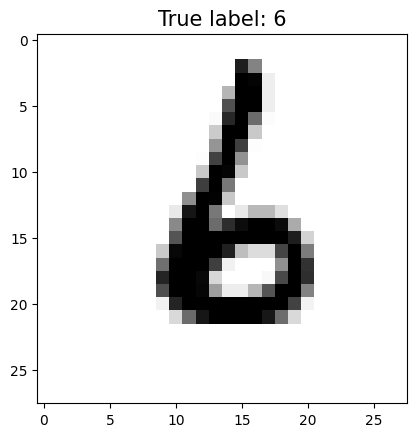

In [256]:
test_idx = 0
test_sample = test[test_idx]
img_test_sample = torch.clip(test.inverse_transform(test_sample[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {test_sample[1]}", fontsize=15)
plt.imshow(img_test_sample, cmap = "gray_r")
plt.show()

c:\Users\weckbecker\DualView-wip\.venv\Lib\site-packages\zennit\image.py:184: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)
c:\Users\weckbecker\DualView-wip\.venv\Lib\site-packages\zennit\image.py:185: RuntimeWarning: invalid value encountered in cast
  array = (array * 255).clip(0, 255).astype(np.uint8)


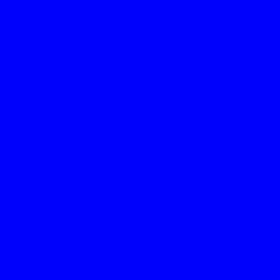

In [257]:
### STILL NEEDS TO BE MULTIPLIED WITH DATA ATTRIBUTION VALUE

composite = EpsilonGammaBox(low=-3., high=3.)
mode = "train"

with torch.no_grad():
    train_features = mnist_model.features(train_sample[0].unsqueeze(dim = 0))
    test_features = mnist_model.features(test_sample[0].unsqueeze(dim = 0))
    attr_output = test_features * (xpl[test_idx, train_idx] / (train_features @ test_features.T)) if mode == "train" else train_features * (xpl[test_idx, train_idx] / (train_features @ test_features.T))

with Gradient(model=mnist_model.features, composite=composite) as attributor:
    out, relevance = attributor(train_sample[0].unsqueeze(dim=0), attr_output)

relevance = relevance[0].sum(0).detach().cpu()

img = imgify(relevance, cmap='bwr', symmetric = True)
img = img.resize((28 * 10, 28 * 10))
display(img)

# well, the xpl value is 0...

c:\Users\weckbecker\DualView-wip\.venv\Lib\site-packages\zennit\image.py:184: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)
c:\Users\weckbecker\DualView-wip\.venv\Lib\site-packages\zennit\image.py:185: RuntimeWarning: invalid value encountered in cast
  array = (array * 255).clip(0, 255).astype(np.uint8)


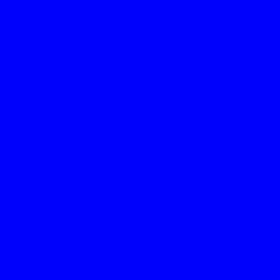

<PIL.Image.Image image mode=P size=28x28 at 0x202C09DF110>


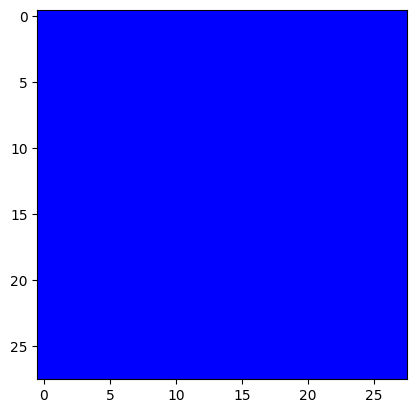

In [28]:
### STILL NEEDS TO BE MULTIPLIED WITH DUAL VALUE

composite = EpsilonGammaBox(low=-3., high=3.)
mode = "test"

with torch.no_grad():
    train_features = mnist_model.features(train_sample[0].unsqueeze(dim = 0))
    test_features = mnist_model.features(test_sample[0].unsqueeze(dim = 0))
    attr_output = test_features * (xpl[test_idx, train_idx] / (train_features @ test_features.T)) if mode == "train" else train_features * (xpl[test_idx, train_idx] / (train_features @ test_features.T))

with Gradient(model=mnist_model.features, composite=composite) as attributor:
    out, relevance = attributor(test_sample[0].unsqueeze(dim=0), attr_output)

relevance = relevance[0].sum(0).detach().cpu()

img = imgify(relevance, cmap='bwr', symmetric = True)
img = img.resize((28 * 10, 28 * 10))
display(img)

img = display_tda_lrp(train_sample, test_sample, train_idx, test_idx, xpl, model=mnist_model, mode = 'test')
plt.imshow(img)
plt.show()
#xpl value is 0

# I. Create LRP vs. DuaLRP overview (train + test)

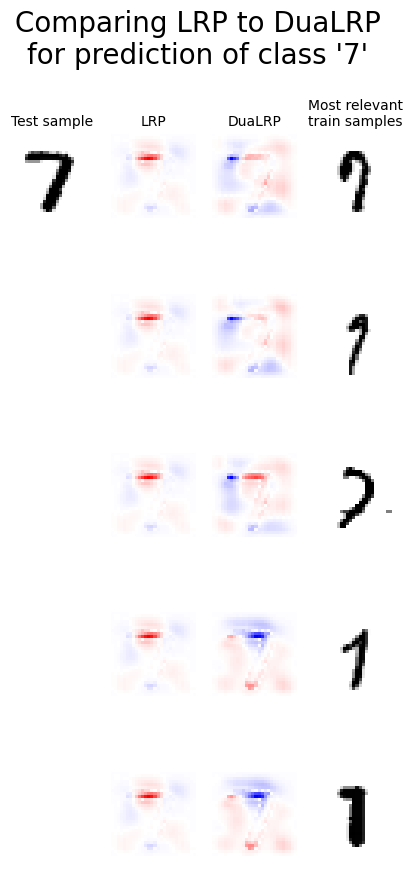

In [23]:
nrows = 5
test_idx = 1
most_relevant = True

test_sample = test[test_idx]
if most_relevant == True:
    train_indices = torch.topk(xpl[test_idx], nrows).indices
else:
    train_indices = torch.topk(-xpl[test_idx], nrows).indices


fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(5, 10))
for ax in axes.flatten():
    ax.axis('off')

# populate
# Column 1: Test image (first row only)
axes[0,0].imshow(display_img(test_sample, test), cmap='gray_r')

# Column 2: Test image LRP (first row only)
#axes[0,1].imshow(display_lrp(test_sample, mnist_model))

# Column 2: Test image LRP (for all rows)
for i in range(nrows):
    axes[i,1].imshow(display_lrp(test_sample, mnist_model, composite=EpsilonPlus()))

# Column 3: Test image DuaLRP for different train points (all rows)
for i in range(nrows):
    axes[i,2].imshow(display_tda_lrp(train[train_indices[i]], test_sample, train_indices[i], test_idx, xpl, mnist_model, mode = "test", composite=EpsilonPlus()))
    
# Column 4: Train iamges (all rows)
for i in range(nrows):
    axes[i,3].imshow(display_img(train[train_indices[i]], test), cmap='gray_r')
    
plt.suptitle(f"Comparing LRP to DuaLRP\nfor prediction of class '{test_sample[1]}'", fontsize = 20)
axes[0,0].set_title("Test sample", fontsize=10)
axes[0,1].set_title("LRP", fontsize=10)
axes[0,2].set_title("DuaLRP", fontsize=10)
axes[0,3].set_title("Most relevant\ntrain samples", fontsize=10)   
#plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [288]:
nrows = 10
test_idx = 1
most_relevant = True

def compare_lrp_to_tda_lrp_test(test_idx, nrows=10, most_relevant=True, composite = EpsilonPlus()):
    test_sample = test[test_idx]
    if most_relevant == True:
        train_indices = torch.topk(xpl[test_idx], nrows).indices
    else:
        train_indices = torch.topk(-xpl[test_idx], nrows).indices


    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(5, 10))
    for ax in axes.flatten():
        ax.axis('off')

    # populate
    # Column 1: Test image (first row only)
    axes[0,0].imshow(display_img(test_sample, test), cmap='gray_r')

    # Column 2: Test image LRP (first row only)
    axes[0,1].imshow(display_lrp(test_sample, mnist_model, composite = composite))

    # Column 3: Test image DuaLRP for different train points (all rows)
    for i in range(nrows):
        axes[i,2].imshow(display_tda_lrp(train[train_indices[i]], test_sample, train_indices[i], test_idx, xpl,  mnist_model, mode = "test", composite = composite))
        
    # Column 4: Train iamges (all rows)
    for i in range(nrows):
        axes[i,3].imshow(display_img(train[train_indices[i]], test), cmap='gray_r')
        
    plt.suptitle(f"Comparing LRP to DuaLRP\nfor prediction of class '{test_sample[1]}'", fontsize = 20)
    axes[0,0].set_title("Test sample", fontsize=10)
    axes[0,1].set_title("LRP for\ntest sample", fontsize=10)
    axes[0,2].set_title("DuaLRP for\ntest sample", fontsize=10)
    axes[0,3].set_title("Most relevant\ntrain samples", fontsize=10)   
    #plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def compare_lrp_to_tda_lrp_train(test_idx, nrows=10, most_relevant=True, composite = EpsilonPlus()):
    test_sample = test[test_idx]
    if most_relevant == True:
        train_indices = torch.topk(xpl[test_idx], nrows).indices
    else:
        train_indices = torch.topk(-xpl[test_idx], nrows).indices


    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(5, 10))
    for ax in axes.flatten():
        ax.axis('off')

    # populate
    # Column 1: Test image (first row only)
    axes[0,0].imshow(display_img(test_sample, test), cmap='gray_r')

    # Column 2: Test image LRP (first row only)
    for i in range(nrows):
        axes[i,1].imshow(display_lrp(train[train_indices[i]], mnist_model, composite = composite))

    # Column 3: Test image DuaLRP for different train points (all rows)
    for i in range(nrows):
        axes[i,2].imshow(display_tda_lrp(train[train_indices[i]], test_sample, train_indices[i], test_idx, xpl, mnist_model, mode = "train", composite = composite))
        
    # Column 4: Train iamges (all rows)
    for i in range(nrows):
        axes[i,3].imshow(display_img(train[train_indices[i]], test), cmap='gray_r')
        
    plt.suptitle(f"Comparing LRP to DuaLRP\nfor prediction of class '{test_sample[1]}'", fontsize = 20)
    axes[0,0].set_title("Test sample", fontsize=10)
    axes[0,1].set_title("LRP for\ntrain samples", fontsize=10)
    axes[0,2].set_title("DuaLRP for\ntrain samples", fontsize=10)
    axes[0,3].set_title("Most relevant\ntrain samples", fontsize=10)   
    #plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

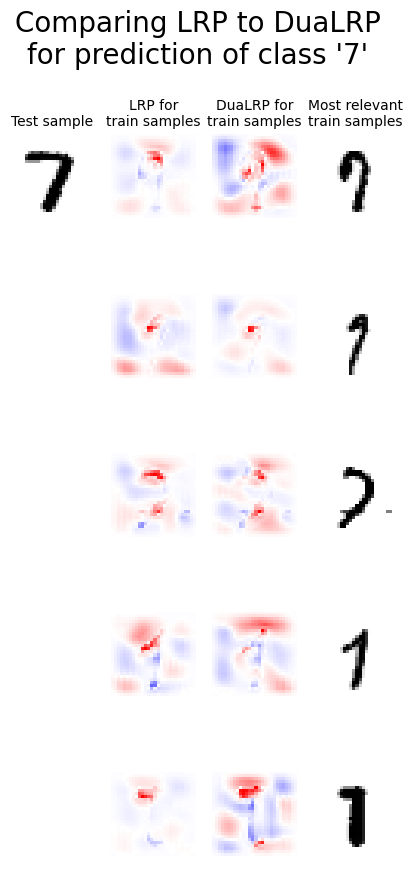

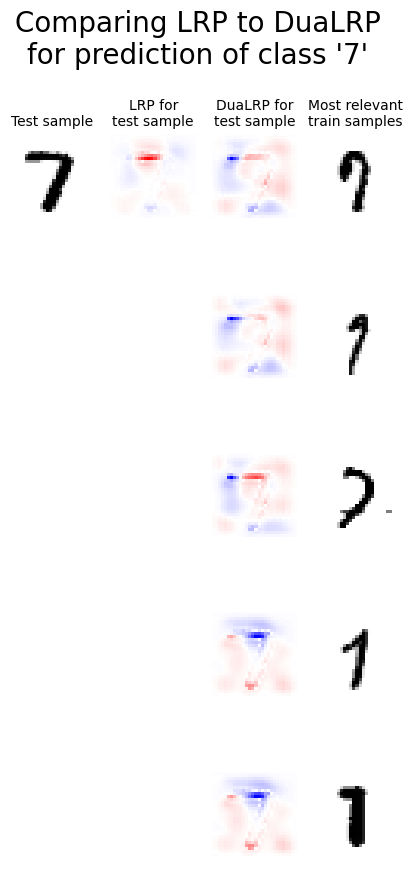

In [289]:
compare_lrp_to_tda_lrp_train(1, 5, True)
compare_lrp_to_tda_lrp_test(1, 5, True)

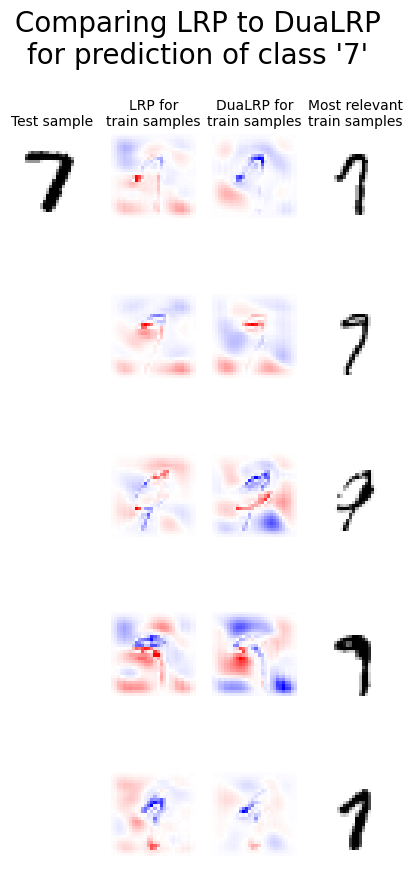

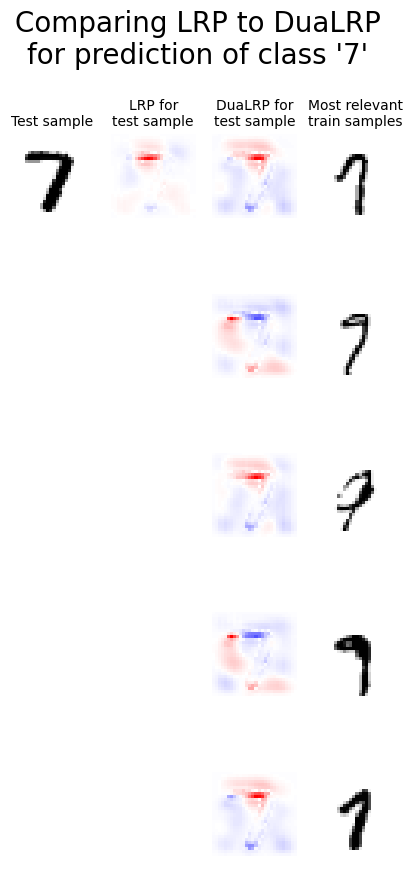

In [290]:
compare_lrp_to_tda_lrp_train(1, 5, False)
compare_lrp_to_tda_lrp_test(1, 5, False)

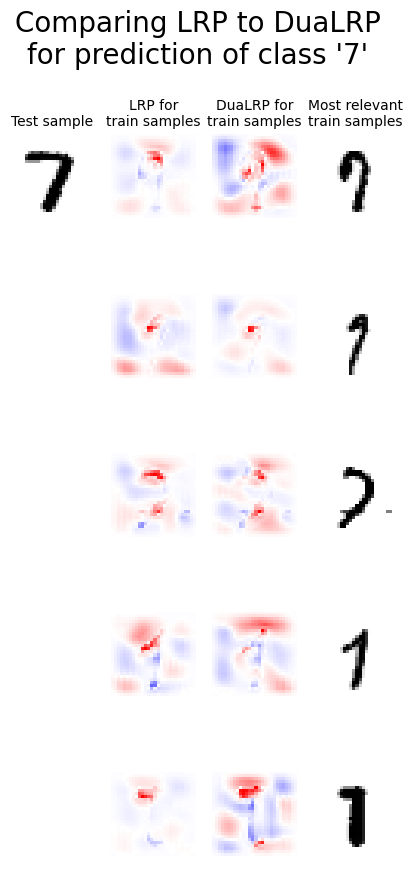

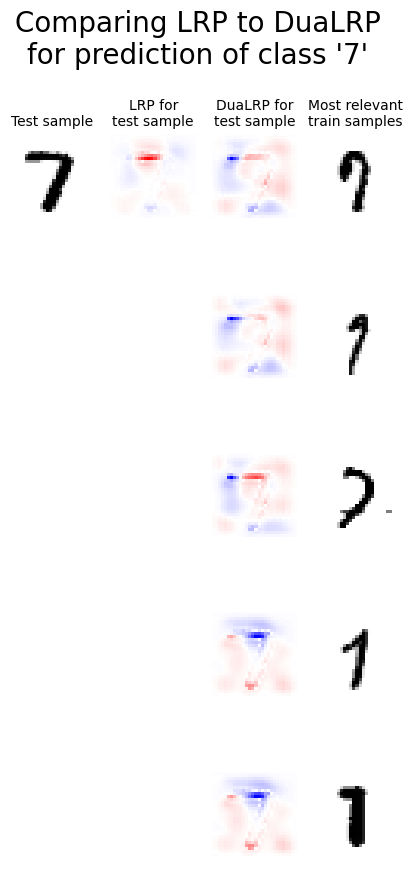

In [291]:
compare_lrp_to_tda_lrp_train(1, 5, True)
compare_lrp_to_tda_lrp_test(1, 5, True)

In [296]:
# Modified version that looks nicer

import matplotlib.patches as patches

nrows = 5
test_idx = 1
most_relevant = True

def add_black_frame(ax):
    """ Adds a black square frame around each subplot """
    rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

def compare_lrp_to_tda_lrp_test(test_idx, nrows=10, most_relevant=True, composite=EpsilonPlus()):
    test_sample = test[test_idx]
    train_indices = torch.topk(xpl[test_idx], nrows).indices if most_relevant else torch.topk(-xpl[test_idx], nrows).indices

    # Adjust figure size and spacing for aesthetics
    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(12, 15))
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    # Turn off axis for all subplots for cleaner visuals
    for ax in axes.flatten():
        ax.axis('off')

    # Column 1: Test image (first row only)
    axes[0, 0].imshow(display_img(test_sample, test), cmap='gray_r')
    axes[0, 0].set_title("Test Sample", fontsize=12)
    add_black_frame(axes[0, 0])

    # Column 2: Test image LRP (first row only)
    axes[0, 1].imshow(display_lrp(test_sample, mnist_model, composite=composite))
    axes[0, 1].set_title("LRP for Test Sample", fontsize=12)
    add_black_frame(axes[0, 1])

    # Column 3: Test image DuaLRP for different train points (all rows)
    for i in range(nrows):
        axes[i,2].imshow(display_tda_lrp(train[train_indices[i]], test_sample, train_indices[i], test_idx, xpl, mnist_model, mode = "test", composite = composite))
        add_black_frame(axes[i, 2])
    axes[0, 2].set_title("DuaLRP for\nTest Sample", fontsize=12)

    # Column 4: Training images (all rows)
    for i in range(nrows):
        axes[i, 3].imshow(display_img(train[train_indices[i]], test), cmap='gray_r')
        add_black_frame(axes[i, 3])
    axes[0, 3].set_title("Train Samples", fontsize=12)

    # Conditional title based on `most_relevant`
    title_relevance = "most positively relevant" if most_relevant else "most negatively relevant"
    plt.suptitle(f"Comparing LRP to DuaLRP\nfor prediction of class '{test_sample[1]}'\nfor the {title_relevance} training points", 
                 fontsize=24, weight='bold', y=1.02)

    plt.show()


def compare_lrp_to_tda_lrp_train(test_idx, nrows=10, most_relevant=True, composite=EpsilonPlus()):
    test_sample = test[test_idx]
    train_indices = torch.topk(xpl[test_idx], nrows).indices if most_relevant else torch.topk(-xpl[test_idx], nrows).indices

    # Adjust figure size and spacing for aesthetics
    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(12, 15))
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    # Turn off axis for all subplots for cleaner visuals
    for ax in axes.flatten():
        ax.axis('off')

    # Column 1: Test image (first row only)
    axes[0, 0].imshow(display_img(test_sample, test), cmap='gray_r')
    axes[0, 0].set_title("Test Sample", fontsize=12)
    add_black_frame(axes[0, 0])

    # Column 2: LRP for training samples (all rows)
    for i in range(nrows):
        axes[i, 1].imshow(display_lrp(train[train_indices[i]], mnist_model, composite=composite))
        add_black_frame(axes[i, 1])
    axes[0, 1].set_title("LRP for\nTrain Samples", fontsize=12)

    # Column 3: Test image DuaLRP for different train points (all rows)
    for i in range(nrows):
        axes[i,2].imshow(display_tda_lrp(train[train_indices[i]], test_sample, train_indices[i], test_idx, xpl, mnist_model, mode = "train", composite = composite))
        add_black_frame(axes[i, 2])
    axes[0, 2].set_title("DuaLRP for\nTrain Samples", fontsize=12)

    # Column 4: Training images (all rows)
    for i in range(nrows):
        axes[i, 3].imshow(display_img(train[train_indices[i]], test), cmap='gray_r')
        add_black_frame(axes[i, 3])
    axes[0, 3].set_title("Train Samples", fontsize=12)

    # Conditional title based on `most_relevant`
    title_relevance = "most positively relevant" if most_relevant else "most negatively relevant"
    plt.suptitle(f"Comparing LRP to DuaLRP\nfor prediction of class '{test_sample[1]}'\nfor the {title_relevance} training points", 
                 fontsize=24, weight='bold', y=1.02)

    plt.show()


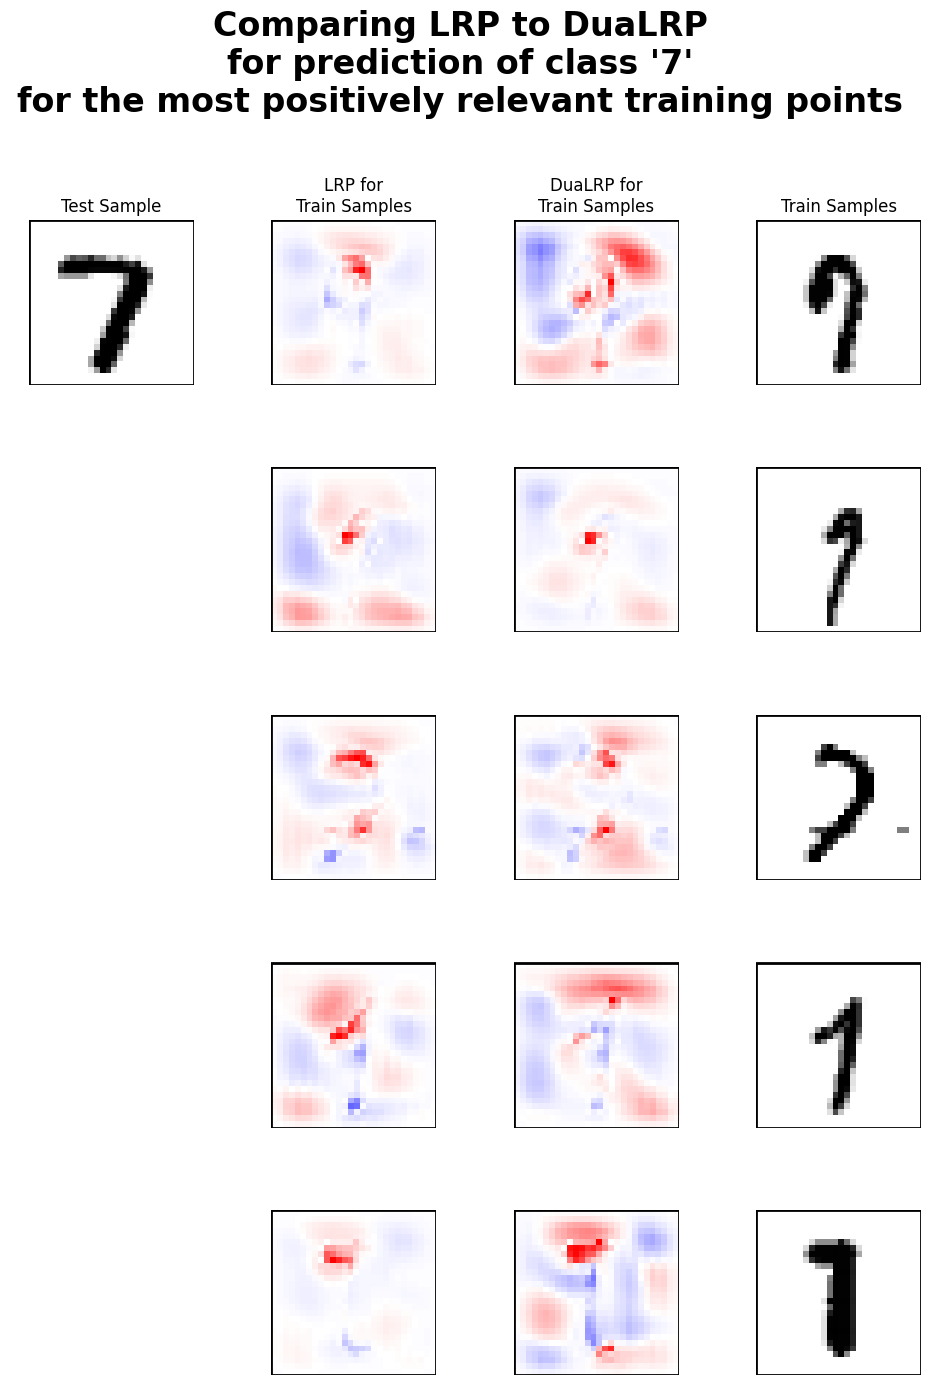

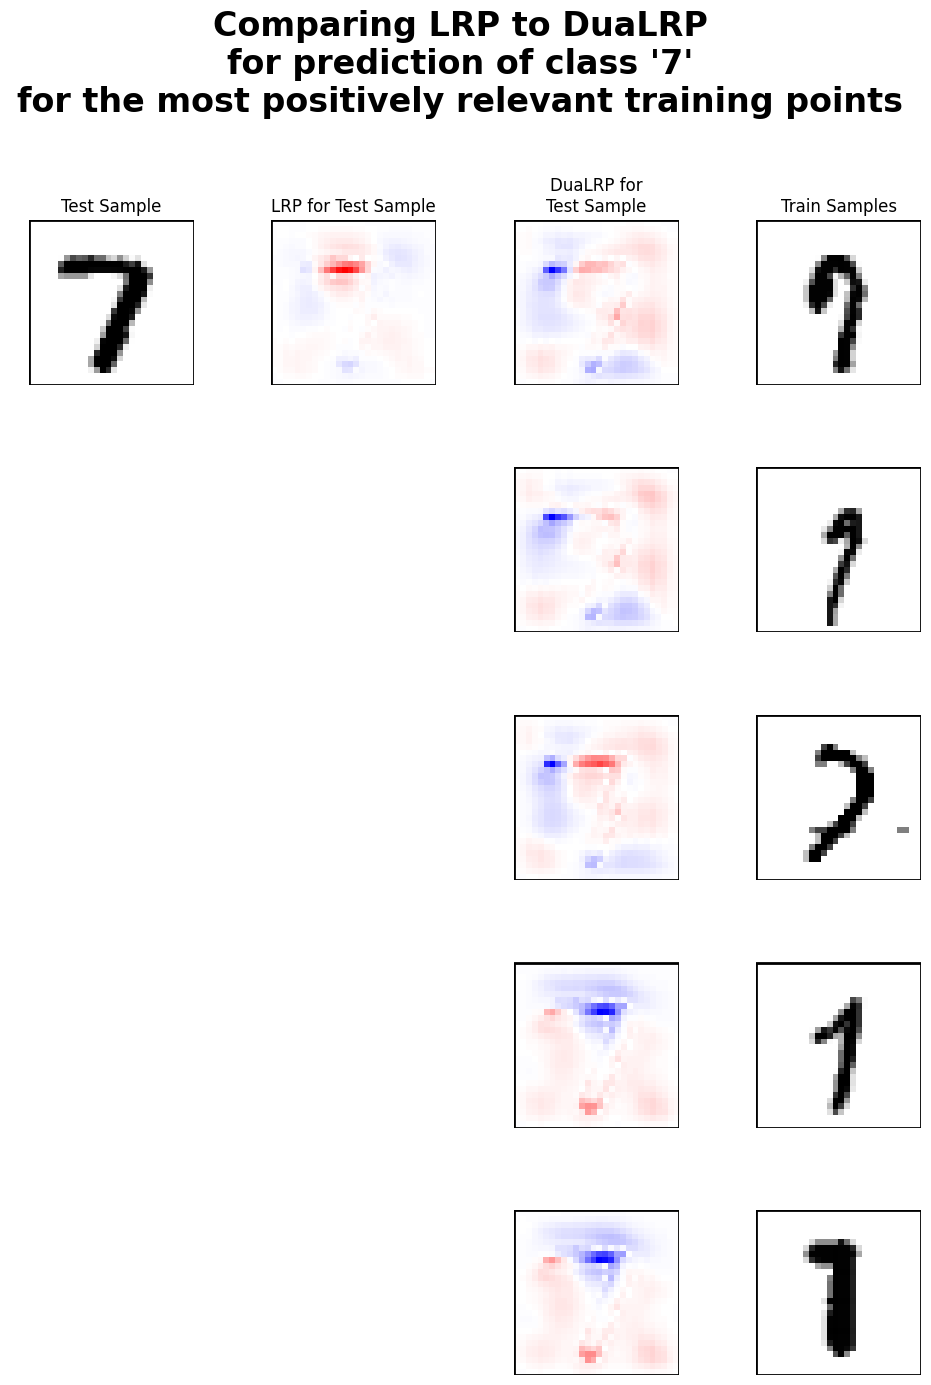

In [297]:
compare_lrp_to_tda_lrp_train(1, 5, True)
compare_lrp_to_tda_lrp_test(1, 5, True)

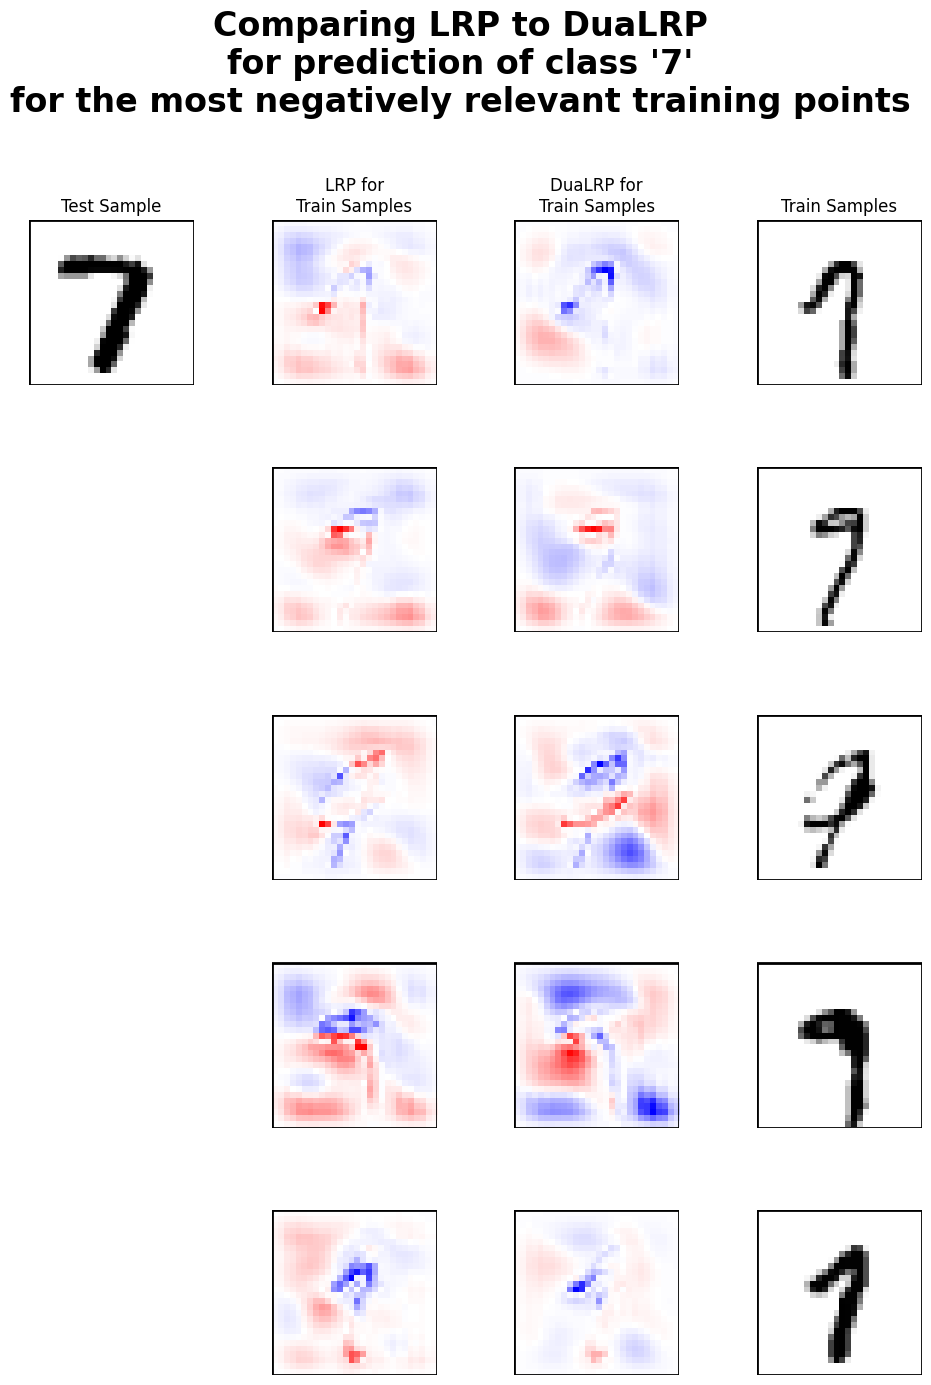

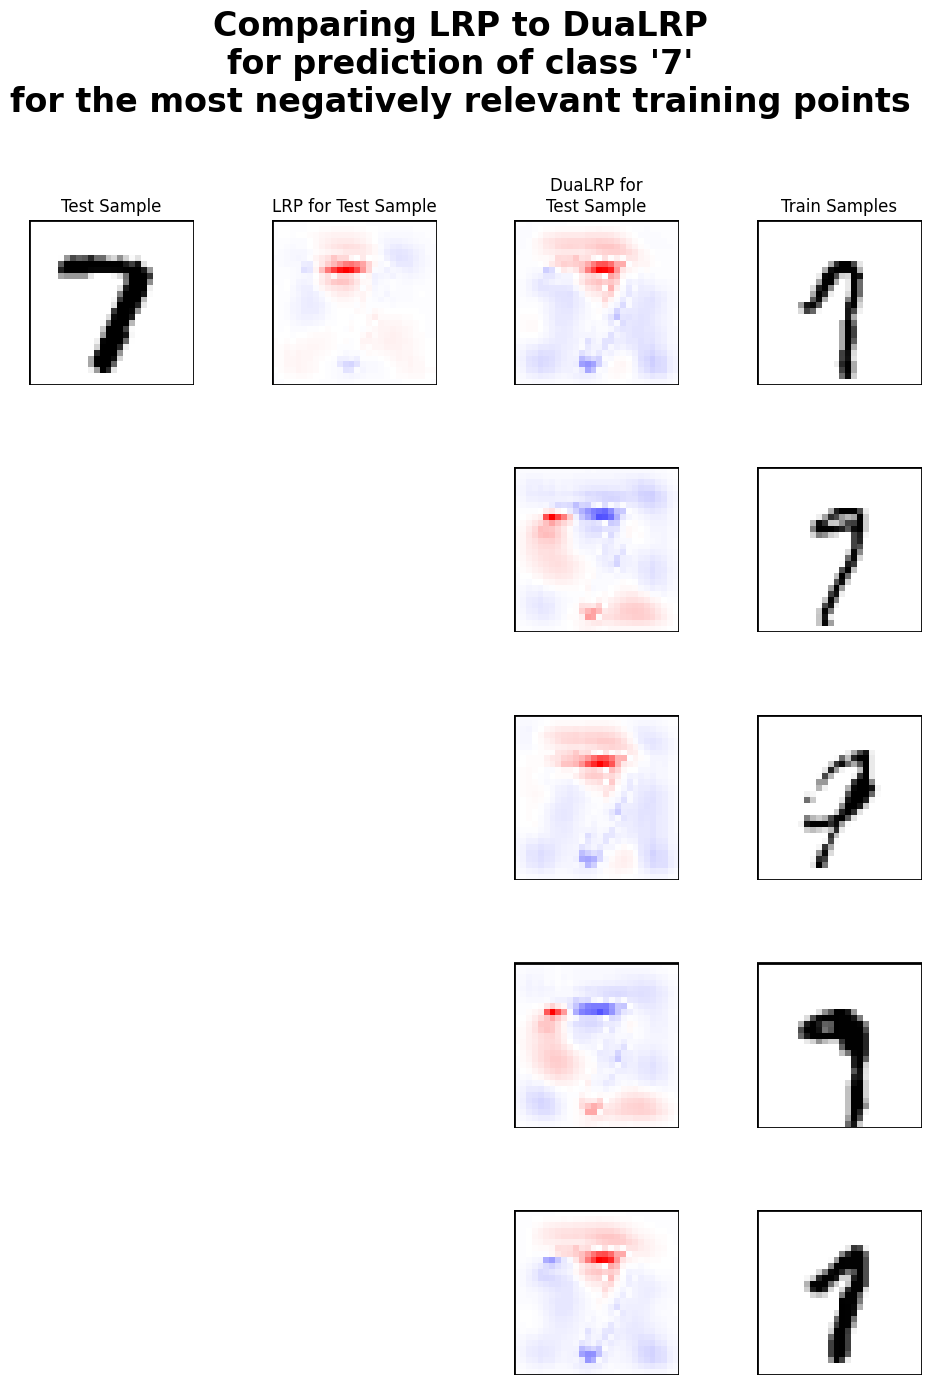

In [298]:
compare_lrp_to_tda_lrp_train(1, 5, False)
compare_lrp_to_tda_lrp_test(1, 5, False)

# II. Pixelflipping with (Dua)LRP

In [358]:
class PixelflipDataset(Dataset):

    @staticmethod
    def pixel_flip(t, flatten_idx_list):
        t_size = t.size()
        t = t.flatten()
        for idx in flatten_idx_list:
            t[idx] = 1-t[idx]
        t = t.reshape(t_size)
        return t

    @staticmethod
    def pixel_turn_off(t, flatten_idx_list):
        t_size = t.size()
        t = t.flatten()
        for idx in flatten_idx_list:
            t[idx] = 0
        t = t.reshape(t_size)
        return t

    def __init__(self, tensor, label, indices, dataset, pixel_per_flip, mode = "flip"):
        self.data = tensor
        self.label = label
        self.transform = dataset.transform
        #self.inverse_transform = transforms.Normalize((0.1307,), (0.3081,)) # I don't think we need this
        self.inverse_transform = dataset.inverse_transform
        #mnist.inverse_transform
        self.indices = indices
        self.pixel_per_flip = pixel_per_flip

    def __len__(self):
        return 28 * 28 // self.pixel_per_flip

    def __getitem__(self, idx):
        img = self.data.clone()
        if mode == "flip":
            img = self.pixel_flip(img, self.indices[:idx*self.pixel_per_flip])
        else:
            img = self.pixel_turn_off(img, self.indices[:idx*self.pixel_per_flip])
        img = Image.fromarray(img.squeeze().numpy(), mode="F")

        if self.transform is not None:
            img = self.transform(img)

        return img, self.label

In [365]:
test_idx = 10
test_sample = test[test_idx]
train_sample = train[xpl[0].argmax()]
lrp_relevance = return_lrp(test_sample, mnist_model).flatten()
lrp_indices = lrp_relevance.argsort(descending=True) 
lrp_tda_relevance = return_tda_lrp(train_sample, test_sample, xpl[0].argmax(), test_idx, xpl, mnist_model, mode = "test").flatten()
lrp_tda_indices = lrp_tda_relevance.argsort(descending=True)

pixelturnoff_lrp = PixelflipDataset(test_sample[0], test_sample[1], lrp_indices, test, pixel_per_flip = 5, mode = "turnoff")
pixelturnoff_lrp_tda = PixelflipDataset(test_sample[0], test_sample[1], lrp_tda_indices, test, pixel_per_flip = 5, mode = "turnoff")

In [366]:
ds_kwargs = {
    'data_root': data_root,
    'class_groups': class_groups,
    'image_set': "test",
    'validation_size': validation_size,
    "only_train": False,
    "transform": None
}
explainer_cls, kwargs = load_explainer(xai_method="dualview", cache_dir = "C:/Users/weckbecker/DualView-wip/cache/MNIST/std/dualview_0.1",
                                       grad_dir = "c:/Users/weckbecker/DualView-wip/cache/MNIST/std/tracin/best",
                                       features_dir = "c:/Users/weckbecker/DualView-wip/cache/MNIST/std/features",
                                       model_path=model_path, dataset_name="MNIST", dataset_type="std")

xpl_lrp = xplain(model=mnist_model,
    train=train,
    test=pixelturnoff_lrp,
    device=device,
    explainer_cls=explainer_cls,
    kwargs=kwargs,
    batch_size=32,
    num_batches_per_file=10,
    save_dir="C:/Users/weckbecker/DualView-wip/explanations/MNIST/pixelflip/basic_conv_std/dualview_lrp",
    start_file=0,
    num_files=500)

xpl_lrp_tda = xplain(
    model=mnist_model,
    train=train,
    test=pixelturnoff_lrp_tda,
    device=device,
    explainer_cls=explainer_cls,
    kwargs=kwargs,
    batch_size=32,
    num_batches_per_file=10,
    save_dir="C:/Users/weckbecker/DualView-wip/explanations/MNIST/pixelflip/basic_conv_std/dualview_lrp_tda",
    start_file=0,
    num_files=500
)

c:\Users\weckbecker\DualView-wip\src\utils\explainers.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(feature_ds.labels, dtype=torch.int, device=self.device)
c:\Users\weckbecker\DualView-wip\.venv\Lib\site-packages\sklearn\svm\_base.py:1238: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training took 2.8627684116363525 seconds
Finished file 00


c:\Users\weckbecker\DualView-wip\src\utils\explainers.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(feature_ds.labels, dtype=torch.int, device=self.device)
c:\Users\weckbecker\DualView-wip\.venv\Lib\site-packages\sklearn\svm\_base.py:1238: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training took 3.3454782962799072 seconds
Finished file 00


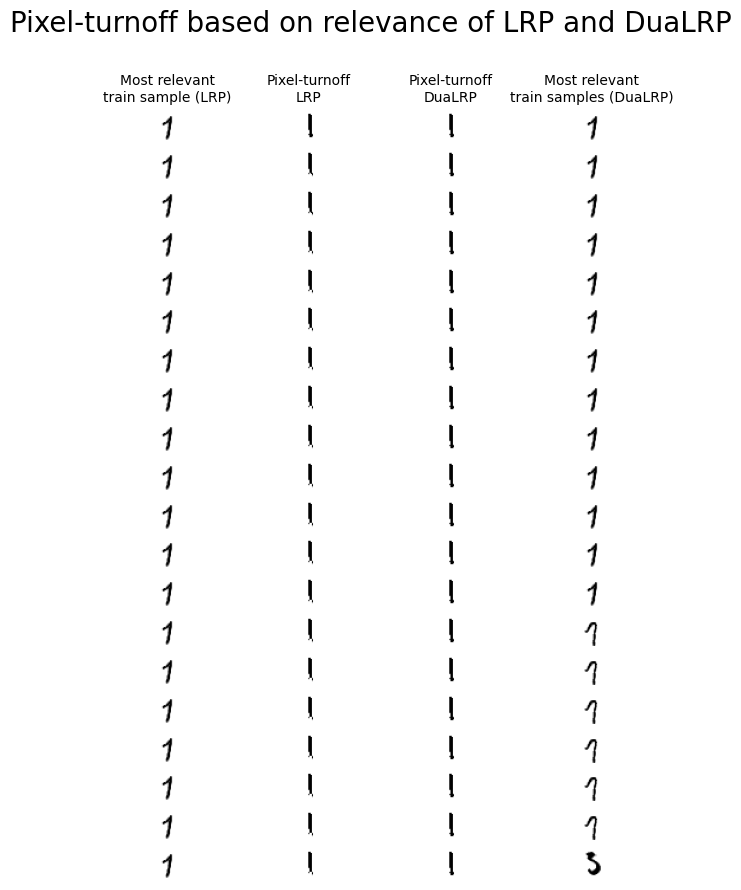

In [367]:
nrows = 20

fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(7, 10))
for ax in axes.flatten():
    ax.axis('off')

# populate
# Column 1: Test image (first row only)
for i in range(nrows):
    #axes[i,0].imshow(display_tda_lrp(train[train_indices[i]], test_sample, xpl[test_idx, train_indices[i]], mnist_model, mode = "test"))
    axes[i,0].imshow(display_img(train[xpl_lrp[i].argmin()][0].unsqueeze(0), train), cmap='gray_r')
 
# Column 2: Test image LRP (first row only)
for i in range(nrows):
    axes[i,1].imshow(display_img(pixelturnoff_lrp[i][0].unsqueeze(0), test), cmap='gray_r')
 
# Column 3: Test image DuaLRP for different train points (all rows)
for i in range(nrows):
    axes[i,2].imshow(display_img(pixelturnoff_lrp_tda[i][0].unsqueeze(0), test), cmap='gray_r')

# Column 4: Train images (all rows)
for i in range(nrows):
    #axes[i,3].imshow(display_img(train[train_indices[i]], test), cmap='gray_r')
    axes[i,3].imshow(display_img(train[xpl_lrp_tda[i].argmin()][0].unsqueeze(0), train), cmap='gray_r')
    
plt.suptitle(f"Pixel-turnoff based on relevance of LRP and DuaLRP", fontsize = 20)
axes[0,0].set_title("Most relevant\ntrain sample (LRP)", fontsize=10)
axes[0,1].set_title("Pixel-turnoff\nLRP", fontsize=10)
axes[0,2].set_title("Pixel-turnoff\nDuaLRP", fontsize=10)
axes[0,3].set_title("Most relevant\ntrain samples (DuaLRP)", fontsize=10)   
#plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

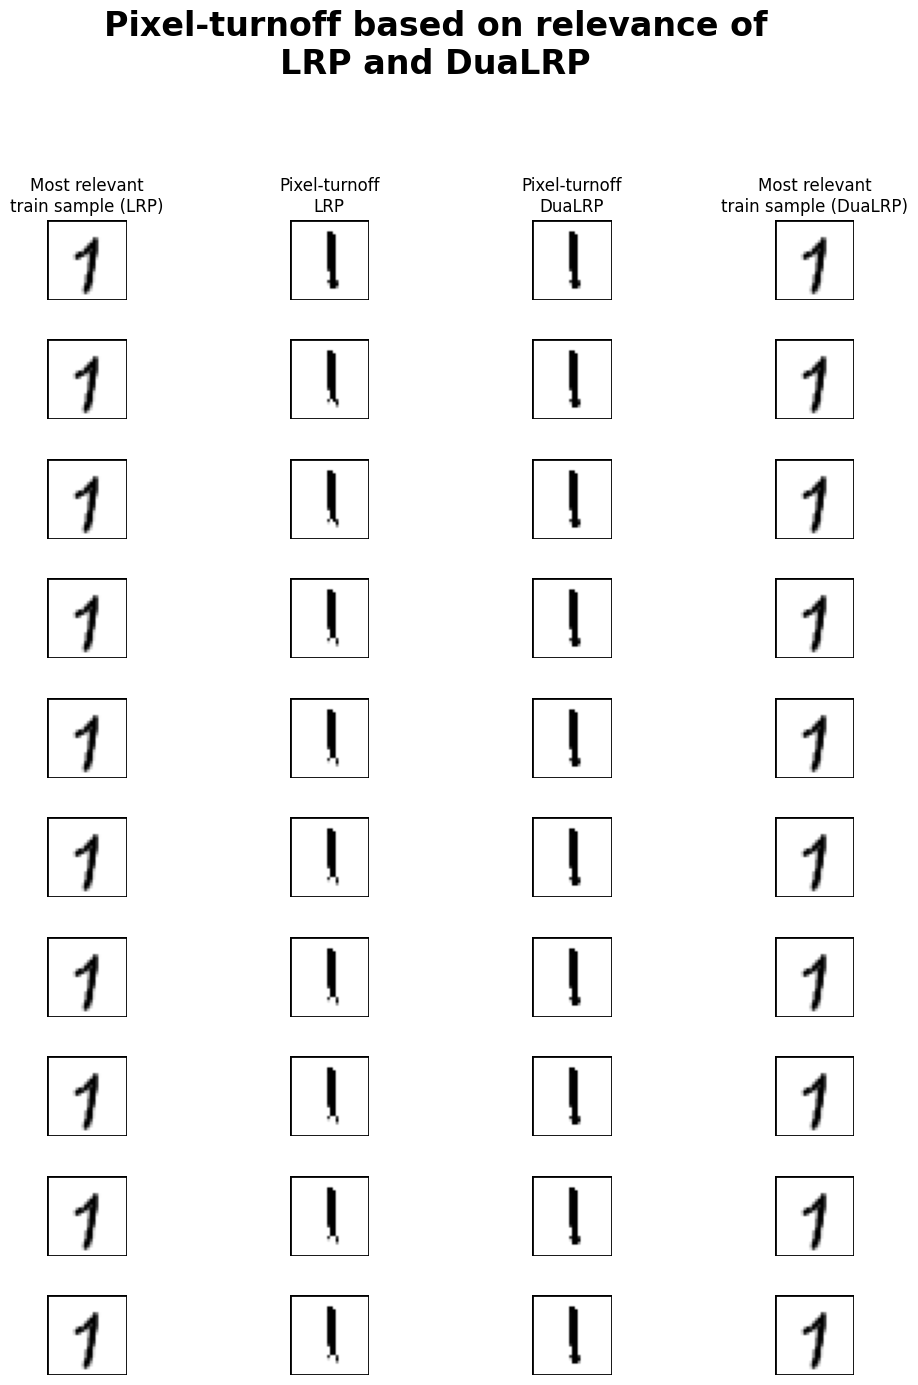

In [368]:
# Updated version (more pretty)

import matplotlib.patches as patches

nrows = 10

def add_black_frame(ax):
    """ Adds a black square frame around each subplot """
    rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

# Create the figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(12, 15))
fig.subplots_adjust(wspace=0.2, hspace=0.5)

# Turn off axes for all subplots for cleaner visuals
for ax in axes.flatten():
    ax.axis('off')

# Populate the subplots
# Column 1: Most relevant train sample based on LRP
for i in range(nrows):
    axes[i, 0].imshow(display_img(train[xpl_lrp[i].argmin()][0].unsqueeze(0), train), cmap='gray_r')
    add_black_frame(axes[i, 0])
axes[0, 0].set_title("Most relevant\ntrain sample (LRP)", fontsize=12)

# Column 2: Pixel-turnoff LRP
for i in range(nrows):
    axes[i, 1].imshow(display_img(pixelturnoff_lrp[i][0].unsqueeze(0), test), cmap='gray_r')
    add_black_frame(axes[i, 1])
axes[0, 1].set_title("Pixel-turnoff\nLRP", fontsize=12)

# Column 3: Pixel-turnoff DuaLRP
for i in range(nrows):
    axes[i, 2].imshow(display_img(pixelturnoff_lrp_tda[i][0].unsqueeze(0), test), cmap='gray_r')
    add_black_frame(axes[i, 2])
axes[0, 2].set_title("Pixel-turnoff\nDuaLRP", fontsize=12)

# Column 4: Most relevant train samples based on DuaLRP
for i in range(nrows):
    axes[i, 3].imshow(display_img(train[xpl_lrp_tda[i].argmin()][0].unsqueeze(0), train), cmap='gray_r')
    add_black_frame(axes[i, 3])
axes[0, 3].set_title("Most relevant\ntrain sample (DuaLRP)", fontsize=12)

# Larger title with line break for clarity
plt.suptitle("Pixel-turnoff based on relevance of\nLRP and DuaLRP", fontsize=24, weight='bold', y=1.02)

# Show the plot
plt.show()


## Implement counting which pixelflip makes the highest attributed datapoint flip first, LRP or DuaLRP?

# III. Superclasses (with pairs 0-1, 2-3, etc)

In [332]:
dataset = 'MNIST'
model = 'basic_conv'
xai_method = 'representer'
dualview_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_root = f"{dualview_root}/src/datasets"
class_groups = [[0,1],[2,3],[4,5],[6,7],[8,9]]
validation_size=2000
num_classes=5
device = "cpu"
dataset_name = "MNIST"
dataset_type = "group"
model_path = f"{dualview_root}/checkpoints/MNIST/group/MNIST_basic_conv_best"
model_name = "basic_conv"

ds_kwargs = {
    'data_root': data_root,
    'class_groups': class_groups,
    'image_set': "test",
    'validation_size': validation_size,
    'only_train': False,
    'transform': None,
    'num_classes': 10
}

train, test = load_datasets(dataset_name, dataset_type, **ds_kwargs)
mnist_model = load_model(model_name, dataset_name, num_classes).to(device)
checkpoint = torch.load(model_path, map_location=device)
mnist_model.load_state_dict(checkpoint["model_state"])
mnist_model.to(device)
mnist_model.eval()
print('\n')
print(mnist_model)

Validation ids:
tensor([7542, 8214, 3698,  ..., 7815, 7438, 3491])
Test ids:
tensor([5886,  911, 6853,  ..., 7126, 5089, 7716])


BasicConvModel(
  (features): Sequential(
    (conv-0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (relu-0): ReLU()
    (conv-1): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (relu-1): ReLU()
    (conv-2): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
    (relu-2): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc-0): Linear(in_features=2420, out_features=500, bias=True)
    (relu-3): ReLU()
    (fc-1): Linear(in_features=500, out_features=100, bias=True)
    (relu-4): ReLU()
  )
  (classifier): Linear(in_features=100, out_features=5, bias=True)
)


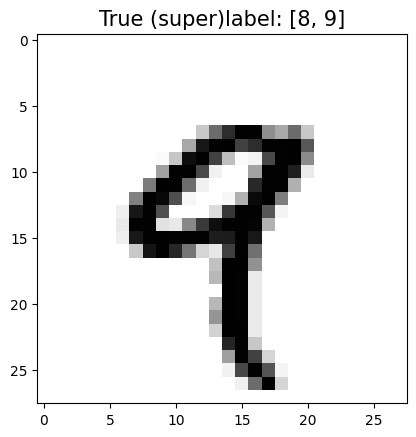

In [333]:
train_sample = train[4]
img_train_sample = torch.clip(train.inverse_transform(train_sample[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True (super)label: {class_groups[train_sample[1][0]]}", fontsize=15)
plt.imshow(img_train_sample, cmap = "gray_r")
plt.show()

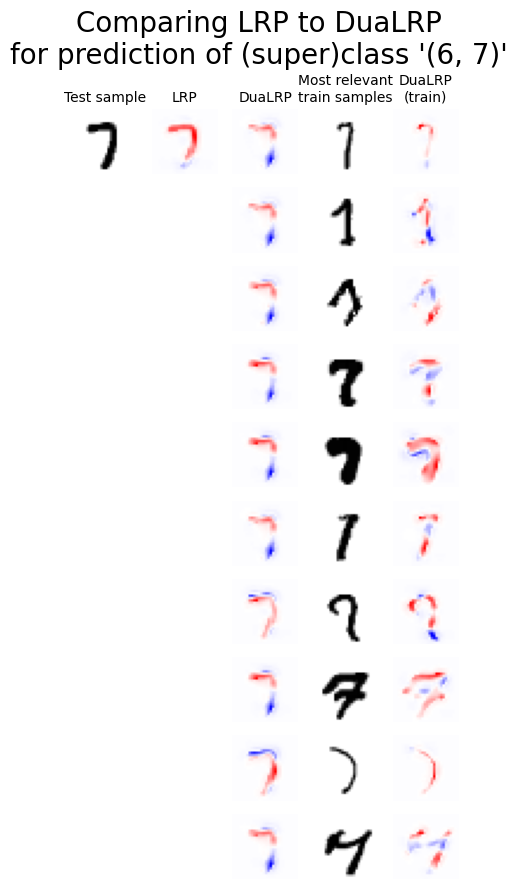

In [345]:
xpl = torch.load('../explanations/MNIST/group/dualview_0.1/DualViewExplainer_00', map_location=torch.device('cpu'))

nrows = 10
test_idx = 2

test_sample = test[test_idx]
train_indices = xpl[test_idx].topk(10).indices


fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(5, 10))
for ax in axes.flatten():
    ax.axis('off')

# populate
# Column 1: Test image (first row only)
axes[0,0].imshow(display_img(test_sample, test), cmap='gray_r')

# Column 2: Test image LRP (first row only)
axes[0,1].imshow(display_lrp(test_sample, mnist_model, class_to_explain=test_sample[1][0]))

# Column 3: Test image DuaLRP for different train points (all rows)
for i in range(nrows):
    axes[i,2].imshow(display_tda_lrp(train[train_indices[i]], test_sample, train_indices[i], test_idx, xpl, mnist_model, mode = "test"))
    
# Column 4: Train iamges (all rows)
for i in range(nrows):
    axes[i,3].imshow(display_img(train[train_indices[i]], test), cmap='gray_r')

# Column 5: Train image DuaLRP for different train points (all rows)
for i in range(nrows):
    axes[i,4].imshow(display_tda_lrp(train[train_indices[i]], test_sample, train_indices[i], test_idx, xpl, mnist_model, mode = "train"))
    
plt.suptitle(f"Comparing LRP to DuaLRP\nfor prediction of (super)class '{test_sample[1][0]*2, test_sample[1][0]*2+1}'", fontsize = 20)
axes[0,0].set_title("Test sample", fontsize=10)
axes[0,1].set_title("LRP", fontsize=10)
axes[0,2].set_title("DuaLRP", fontsize=10)
axes[0,3].set_title("Most relevant\ntrain samples", fontsize=10)
axes[0,4].set_title("DuaLRP\n(train)", fontsize=10)  
#plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# 4. Ablation study with a single train point where we remove a small bit (e.g. changing a six to an eight)

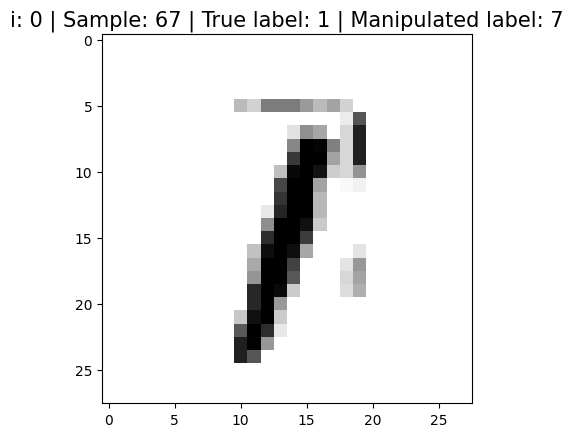

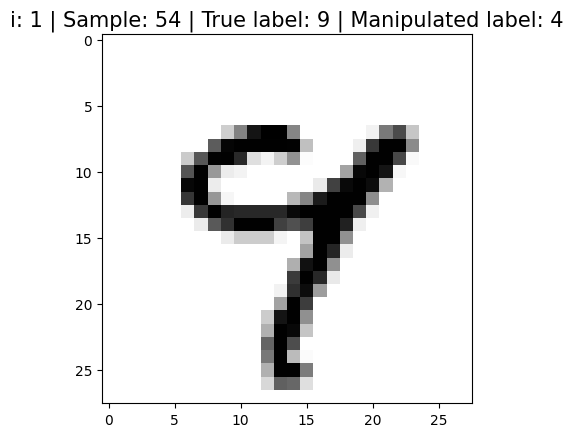

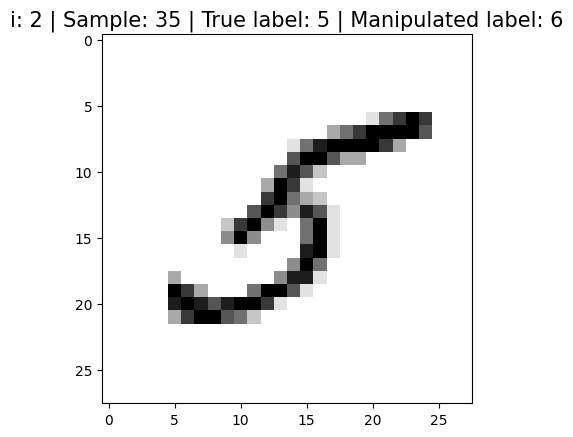

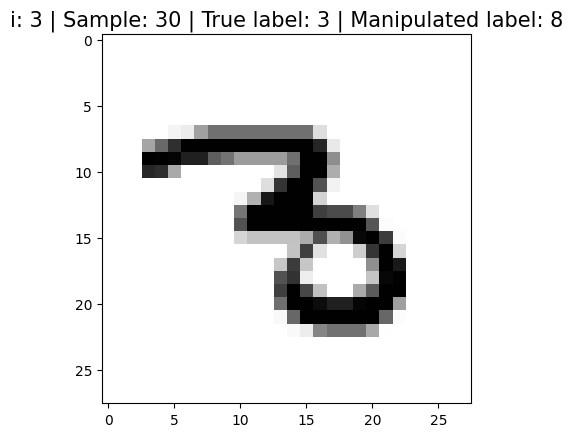

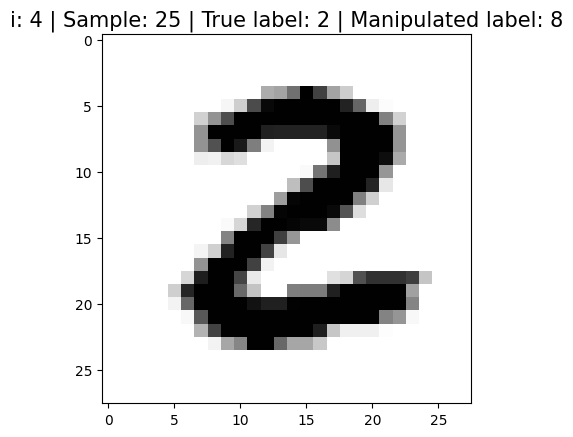

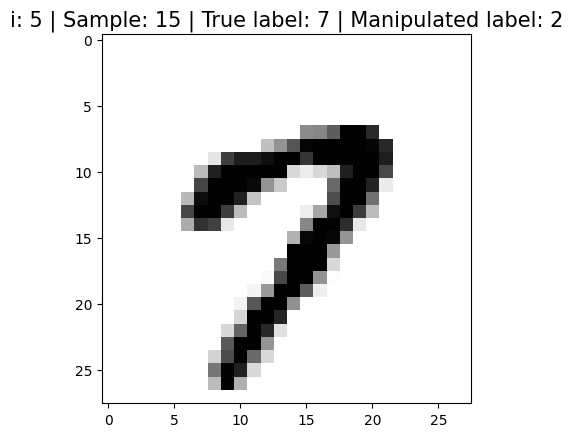

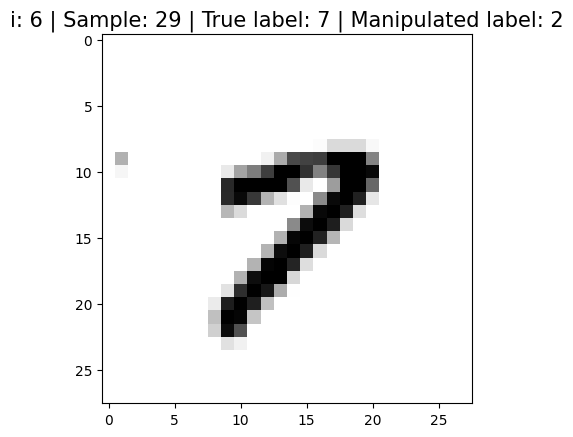

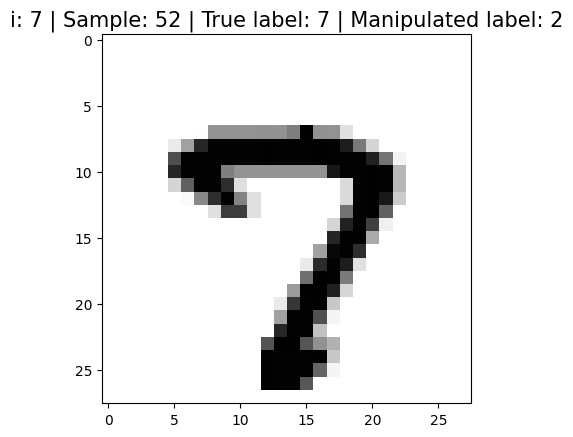

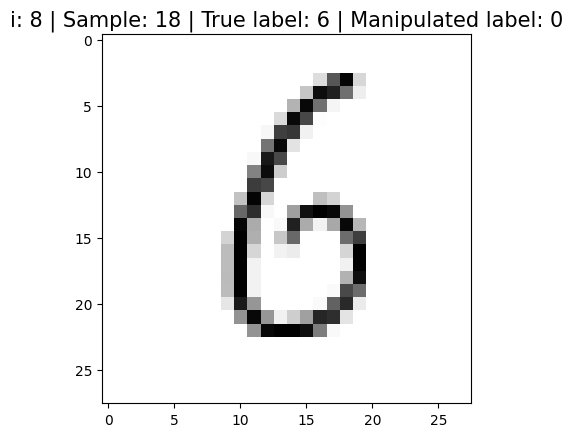

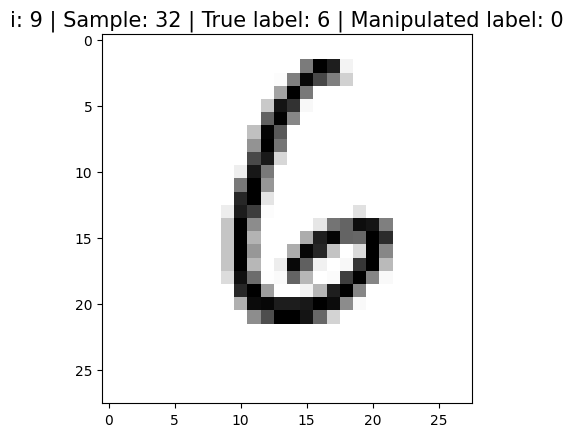

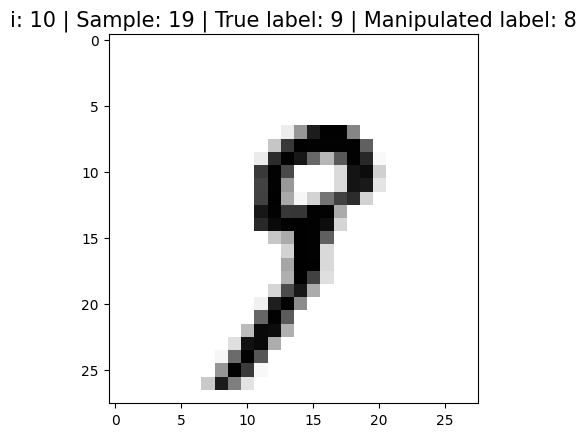

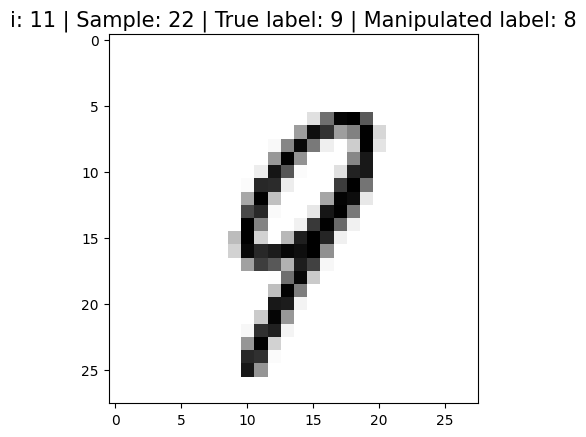

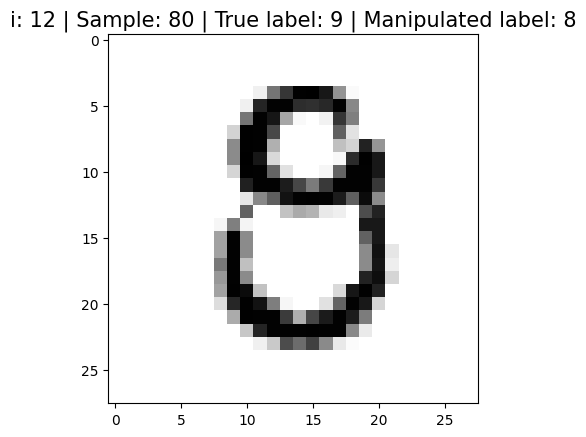

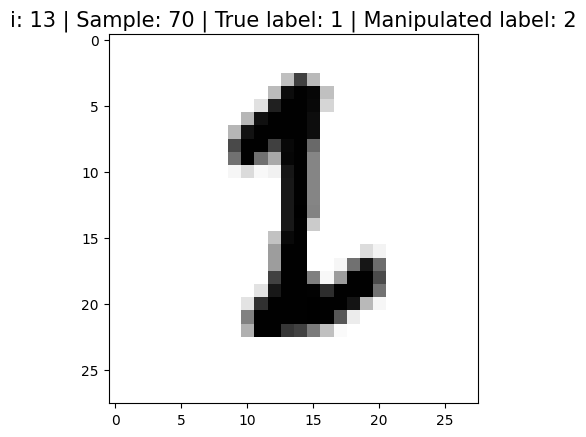

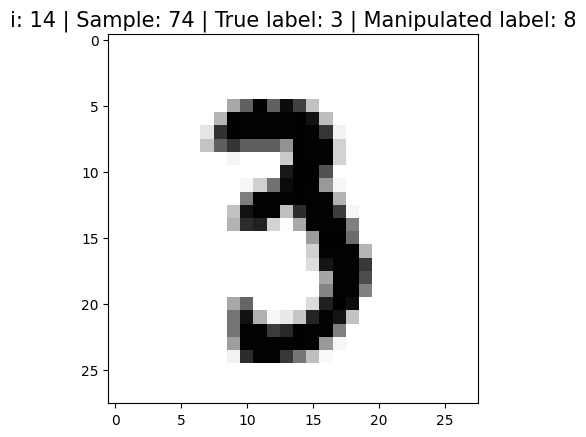

In [ ]:
sample_idx_list = [67, 54, 35, 30, 25, 15, 29, 52, 18, 32, 19, 22, 80, 70, 74]
true_label_list = [1, 9, 5, 3, 2, 7, 7, 7, 6, 6, 9, 9, 9, 1, 3]
manipulated_label_list = [7, 4, 6, 8, 8, 2, 2, 2, 0, 0, 8, 8, 8, 2, 8]

for i in range(15):
    sample_idx = sample_idx_list[i]
    true_label = true_label_list[i]
    manipulated_label = manipulated_label_list[i]

    train_sample = train[sample_idx]
    img_train_sample = torch.clip(train.inverse_transform(train_sample[0].clone().detach()), min=0., max=1.).squeeze()


    plt.title(f"i: {i} | Sample: {sample_idx} | True label: {true_label} | Manipulated label: {manipulated_label}", fontsize=15)
    plt.imshow(img_train_sample, cmap = "gray_r")
    plt.show()

In [ ]:
sample_idx_list = [67, 54, 35, 30, 25, 15, 29, 52, 18, 32, 19, 22, 80, 70, 74]
true_label_list = [1, 9, 5, 3, 2, 7, 7, 7, 6, 6, 9, 9, 9, 1, 3]
manipulated_label_list = [7, 4, 6, 8, 8, 2, 2, 2, 0, 0, 8, 8, 8, 2, 8]

i = 0

sample_idx = sample_idx_list[i]
true_label = true_label_list[i]
manipulated_label = manipulated_label_list[i]

train_sample = train[sample_idx]
img_train_sample = torch.clip(train.inverse_transform(train_sample[0].clone().detach()), min=0., max=1.).squeeze()

eval = evaluate_sample(model, train, img_train_sample)

plt.title(f"Original | Predicted: {eval[0]} | Prob: {eval[1]:.2}", fontsize=15)
plt.imshow(img_train_sample, cmap = "gray_r")
plt.show()

train_sample_manipulated = train_sample[0].clone().detach()
img_train_sample_manipulated = torch.clip(train.inverse_transform(train_sample_manipulated), min=0., max=1.).squeeze()
img_train_sample_manipulated[5:7, 4:9] = 1

eval_manipualted = evaluate_sample(model, train, img_train_sample_manipulated)

plt.title(f"Manipulated | Predicted: {eval_manipualted[0]} | Prob: {eval_manipualted[1]:.2}", fontsize=15)
plt.imshow(img_train_sample_manipulated, cmap = "gray_r")
plt.show()

AttributeError: 'GroupLabelDataset' object has no attribute 'transform'

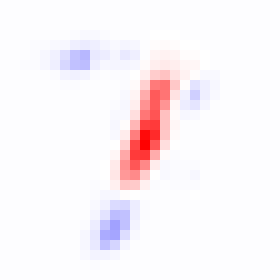

In [ ]:
composite = EpsilonGammaBox(low=-3., high=3.)

class_to_explain = 1

with Gradient(model=model, composite=composite) as attributor:
    out, relevance = attributor(train.transform(img_train_sample_manipulated.numpy()).unsqueeze(dim=0), torch.eye(num_classes)[[class_to_explain]])

relevance = relevance[0].sum(0).detach().cpu()

img = imgify(relevance, cmap='bwr', symmetric = True)
img = img.resize((28 * 10, 28 * 10))
display(img)

C:\Users\weckbecker\AppData\Local\Temp\ipykernel_16380\3669988970.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(model(train.transform(t.numpy()).unsqueeze(dim=0))[0])


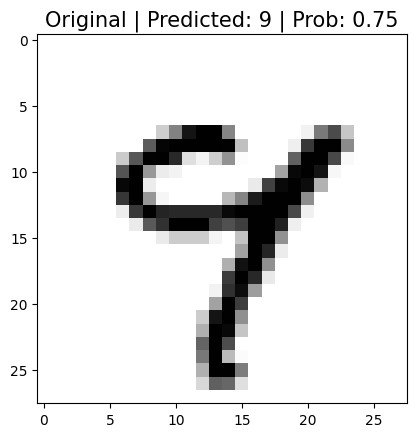

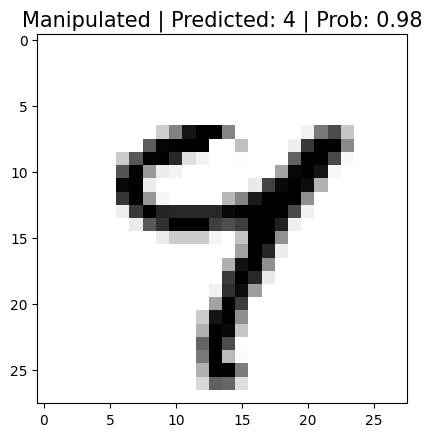

In [ ]:
sample_idx_list = [67, 54, 35, 30, 25, 15, 29, 52, 18, 32, 19, 22, 80, 70, 74]
true_label_list = [1, 9, 5, 3, 2, 7, 7, 7, 6, 6, 9, 9, 9, 1, 3]
manipulated_label_list = [7, 4, 6, 8, 8, 2, 2, 2, 0, 0, 8, 8, 8, 2, 8]

i = 1

sample_idx = sample_idx_list[i]
true_label = true_label_list[i]
manipulated_label = manipulated_label_list[i]

train_sample = train[sample_idx]
img_train_sample = torch.clip(train.inverse_transform(train_sample[0].clone().detach()), min=0., max=1.).squeeze()

eval = evaluate_sample(model, train, img_train_sample)

plt.title(f"Original | Predicted: {eval[0]} | Prob: {eval[1]:.2}", fontsize=15)
plt.imshow(img_train_sample, cmap = "gray_r")
plt.show()

train_sample_manipulated = train_sample[0].clone().detach()
img_train_sample_manipulated = torch.clip(train.inverse_transform(train_sample_manipulated), min=0., max=1.).squeeze()
img_train_sample_manipulated[8:10, 13:15] = 0

eval_manipualted = evaluate_sample(model, train, img_train_sample_manipulated)

plt.title(f"Manipulated | Predicted: {eval_manipualted[0]} | Prob: {eval_manipualted[1]:.2}", fontsize=15)
plt.imshow(img_train_sample_manipulated, cmap = "gray_r")
plt.show()

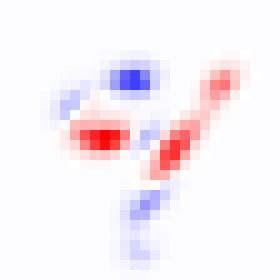

In [ ]:
composite = EpsilonGammaBox(low=-3., high=3.)

class_to_explain = 4

with Gradient(model=model, composite=composite) as attributor:
    out, relevance = attributor(train.transform(img_train_sample.numpy()).unsqueeze(dim=0), torch.eye(num_classes)[[class_to_explain]])

relevance = relevance[0].sum(0).detach().cpu()

img = imgify(relevance, cmap='bwr', symmetric = True)
img = img.resize((28 * 10, 28 * 10))
display(img)

C:\Users\weckbecker\AppData\Local\Temp\ipykernel_16380\3669988970.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(model(train.transform(t.numpy()).unsqueeze(dim=0))[0])


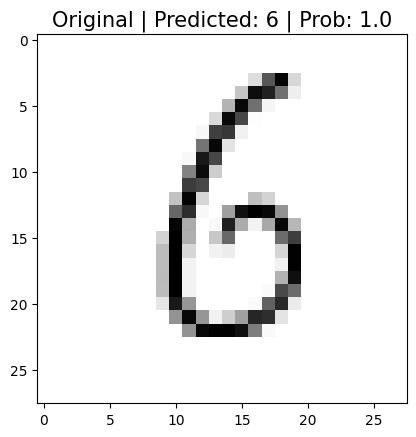

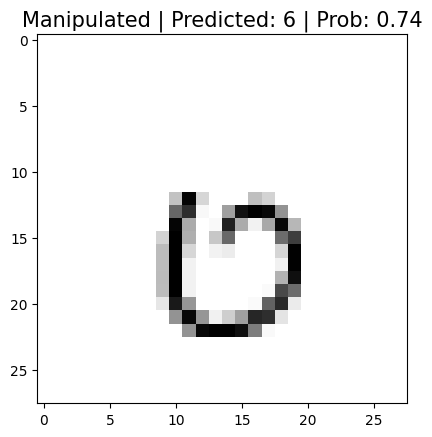

In [ ]:
sample_idx_list = [67, 54, 35, 30, 25, 15, 29, 52, 18, 32, 19, 22, 80, 70, 74]
true_label_list = [1, 9, 5, 3, 2, 7, 7, 7, 6, 6, 9, 9, 9, 1, 3]
manipulated_label_list = [7, 4, 6, 8, 8, 2, 2, 2, 0, 0, 8, 8, 8, 2, 8]

i = 8

sample_idx = sample_idx_list[i]
true_label = true_label_list[i]
manipulated_label = manipulated_label_list[i]

train_sample = train[sample_idx]
img_train_sample = torch.clip(train.inverse_transform(train_sample[0].clone().detach()), min=0., max=1.).squeeze()

eval = evaluate_sample(model, train, img_train_sample)

plt.title(f"Original | Predicted: {eval[0]} | Prob: {eval[1]:.2}", fontsize=15)
plt.imshow(img_train_sample, cmap = "gray_r")
plt.show()

train_sample_manipulated = train_sample[0].clone().detach()
img_train_sample_manipulated = torch.clip(train.inverse_transform(train_sample_manipulated), min=0., max=1.).squeeze()
img_train_sample_manipulated[3:12, 8:20] = 0

eval_manipualted = evaluate_sample(model, train, img_train_sample_manipulated)

plt.title(f"Manipulated | Predicted: {eval_manipualted[0]} | Prob: {eval_manipualted[1]:.2}", fontsize=15)
plt.imshow(img_train_sample_manipulated, cmap = "gray_r")
plt.show()

C:\Users\weckbecker\AppData\Local\Temp\ipykernel_16380\3669988970.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(model(train.transform(t.numpy()).unsqueeze(dim=0))[0])


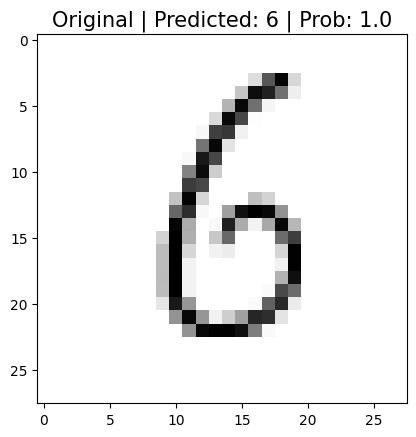

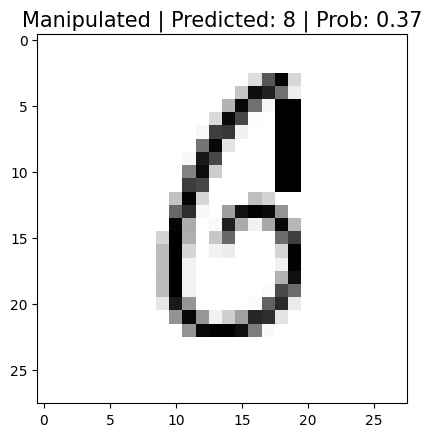

In [ ]:
sample_idx_list = [67, 54, 35, 30, 25, 15, 29, 52, 18, 32, 19, 22, 80, 70, 74]
true_label_list = [1, 9, 5, 3, 2, 7, 7, 7, 6, 6, 9, 9, 9, 1, 3]
manipulated_label_list = [7, 4, 6, 8, 8, 2, 2, 2, 0, 0, 8, 8, 8, 2, 8]

i = 8

sample_idx = sample_idx_list[i]
true_label = true_label_list[i]
manipulated_label = manipulated_label_list[i]

train_sample = train[sample_idx]
img_train_sample = torch.clip(train.inverse_transform(train_sample[0].clone().detach()), min=0., max=1.).squeeze()

eval = evaluate_sample(model, train, img_train_sample)

plt.title(f"Original | Predicted: {eval[0]} | Prob: {eval[1]:.2}", fontsize=15)
plt.imshow(img_train_sample, cmap = "gray_r")
plt.show()

train_sample_manipulated = train_sample[0].clone().detach()
img_train_sample_manipulated = torch.clip(train.inverse_transform(train_sample_manipulated), min=0., max=1.).squeeze()
img_train_sample_manipulated[5:12, 18:20] = 1

eval_manipualted = evaluate_sample(model, train, img_train_sample_manipulated)

plt.title(f"Manipulated | Predicted: {eval_manipualted[0]} | Prob: {eval_manipualted[1]:.2}", fontsize=15)
plt.imshow(img_train_sample_manipulated, cmap = "gray_r")
plt.show()

## IDEA: Create conjoint test points by gluing together half of one training point and half of the other, show differences in attributions when compared to each of the original two testpoints (ideally very different)

In [ ]:
class_idx_dict = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    4 : [],
    5 : [],
    6 : [],
    7 : [],
    8 : [],
    9 : [],
}

for i in range(len(train)):
    class_idx_dict[int(train[i][1])].append(i)

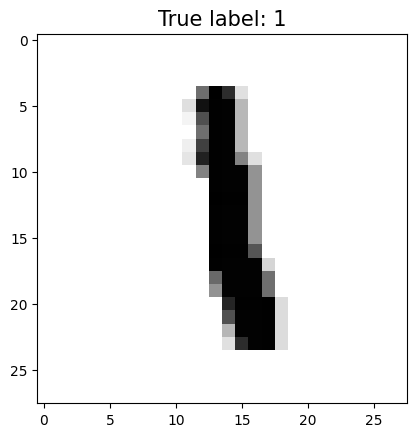

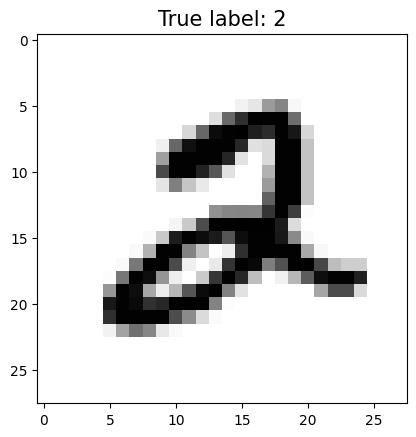

In [ ]:
train_sample_0 = train[class_idx_dict[1][1]]
img_train_sample = torch.clip(train.inverse_transform(train_sample_0[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {train_sample_0[1]}", fontsize=15)
plt.imshow(img_train_sample, cmap = "gray_r")
plt.show()

train_sample_1 = train[class_idx_dict[2][0]]
img_train_sample = torch.clip(train.inverse_transform(train_sample_1[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {train_sample_1[1]}", fontsize=15)
plt.imshow(img_train_sample, cmap = "gray_r")
plt.show()

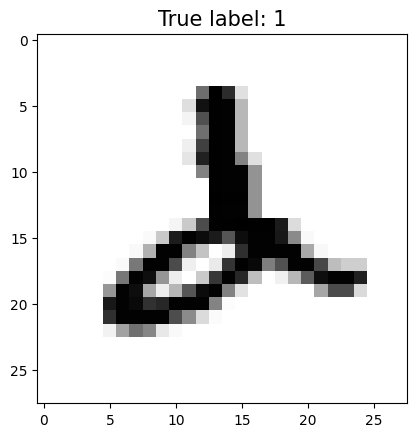

In [ ]:
train_conjoint = (torch.empty((1,28,28)), train_sample_0[1])
train_conjoint[0][:,:14,:] = train_sample_0[0][:,:14,:]
train_conjoint[0][:,14:,:] = train_sample_1[0][:,14:,:]

img_train_sample = torch.clip(train.inverse_transform(train_conjoint[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {train_conjoint[1]}", fontsize=15)
plt.imshow(img_train_sample, cmap = "gray_r")
plt.show()

### Create LRP attributions

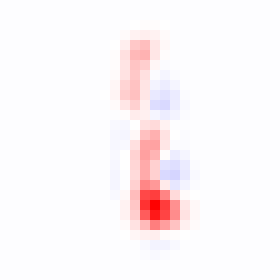

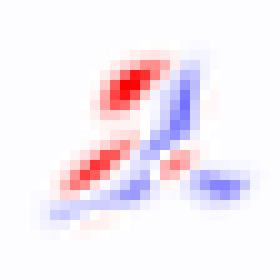

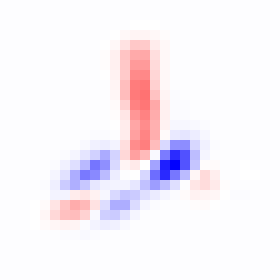

In [ ]:


display_lrp(train_sample_0, model, train_sample_0[1])
display_lrp(train_sample_1, model, train_sample_0[1])
display_lrp(train_conjoint, model, train_sample_0[1])

### Create TDA+LRP attributions

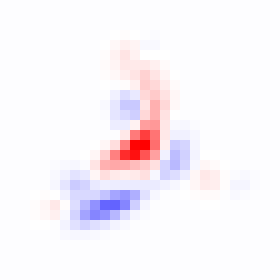

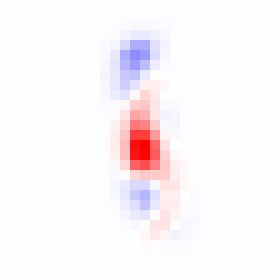

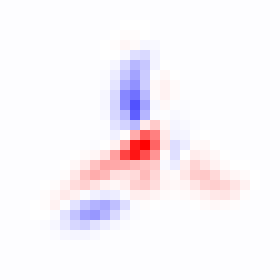

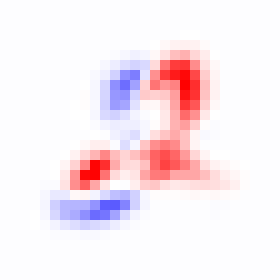

In [ ]:
def display_tda_lrp(train_input, test_input, model, mode = "train", class_to_explain = None):

    ### STILL NEEDS TO BE MULTIPLIED WITH DATA ATTRIBUTION VALUE

    composite = EpsilonGammaBox(low=-3., high=3.)

    if class_to_explain == None:
        class_to_explain = test_input[1]

    with torch.no_grad():
        train_features = model.features(train_input[0].unsqueeze(dim = 0))
        test_features = model.features(test_input[0].unsqueeze(dim = 0))
        attr_output = test_features if mode == "train" else train_features

    to_attribute = train_input[0] if mode == "train" else test_input[0]

    with Gradient(model=model.features, composite=composite) as attributor:
        out, relevance = attributor(to_attribute.unsqueeze(dim=0), attr_output)

    relevance = relevance[0].sum(0).detach().cpu()

    img = imgify(relevance, cmap='bwr', symmetric = True)
    img = img.resize((28 * 10, 28 * 10))
    display(img)

display_tda_lrp(train_conjoint, train_sample_0, model, class_to_explain = train_sample_0[1])
display_tda_lrp(train_conjoint, train_sample_0, model, mode = "test", class_to_explain = train_sample_0[1])
display_tda_lrp(train_conjoint, train_sample_1, model, class_to_explain = train_sample_0[1])
display_tda_lrp(train_conjoint, train_sample_1, model, mode = "test", class_to_explain = train_sample_0[1])

## IDEA: Training-data based pointing game (the object that the test and corresponding training data point have in common)

## IDEA: Scenario where a test point is misclassified because an object in the test point looks like a different object in a training point of a different class (not realistic in MNIST) -> qualitative

# 5. PixelFlipping?

# 6. LRP+TDA matrix?

# 7. Try with CIFAR

In [106]:
dualview_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_root = f"{dualview_root}/src/datasets"
class_groups = None
validation_size=2000
num_classes=10
device = "cpu"
dataset_name = "CIFAR"
dataset_type = "std"
model_path = f"{dualview_root}/checkpoints/CIFAR/std/CIFAR_resnet18"
model_name = "resnet"

ds_kwargs = {
    'data_root': data_root,
    'class_groups': class_groups,
    'image_set': "test",
    'validation_size': validation_size,
    'only_train': False,
    'transform': None,
    'num_classes': 10
}

train, test = load_datasets(dataset_name, dataset_type, **ds_kwargs)
model = load_model(model_path, dataset_type, num_classes)
#checkpoint = torch.load(model_path, map_location=device)
#model.load_state_dict(checkpoint["model_state"])
model.to(device)
model.eval()
print('\n')
print(model)

Files already downloaded and verified
Files already downloaded and verified
Validation ids:
tensor([7542, 8214, 3698,  ..., 7815, 7438, 3491])
Test ids:
tensor([5886,  911, 6853,  ..., 7126, 5089, 7716])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): Ba

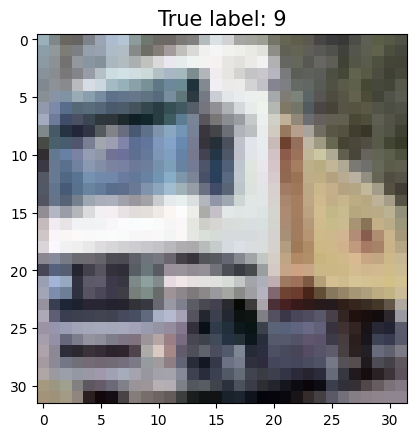

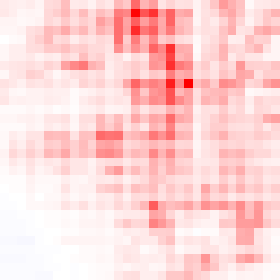

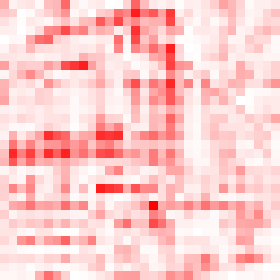

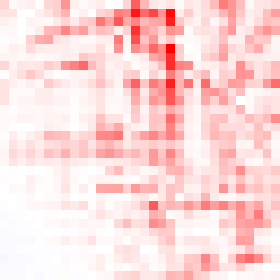

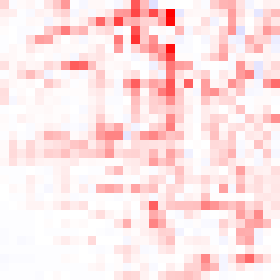

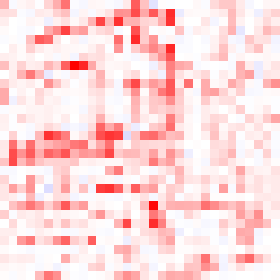

In [116]:
from zennit.composites import DeconvNet, BetaSmooth
from zennit.canonizers import SequentialMergeBatchNorm

train_sample = train[1]
img_train_sample = torch.clip(train.inverse_transform(train_sample[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {train_sample[1]}", fontsize=15)
plt.imshow(img_train_sample.permute(1, 2, 0))
plt.show()

canonizer = SequentialMergeBatchNorm()

composite = EpsilonGammaBox(low=sample_min, high=sample_max, canonizers=[canonizer])
class_to_explain = train_sample[1]

with Gradient(model=model, composite=composite) as attributor:
    out, relevance = attributor(train_sample[0].unsqueeze(dim=0), torch.eye(num_classes)[[class_to_explain]])

relevance = relevance[0].sum(0).detach().cpu()

img = imgify(relevance, cmap='bwr', symmetric = True)
img = img.resize((28 * 10, 28 * 10))
display(img)

for composite in [EpsilonPlusFlat, EpsilonPlus, EpsilonAlpha2Beta1, EpsilonAlpha2Beta1Flat]:
    composite = composite(canonizers=[canonizer])
    class_to_explain = train_sample[1]

    with Gradient(model=model, composite=composite) as attributor:
        out, relevance = attributor(train_sample[0].unsqueeze(dim=0), torch.eye(num_classes)[[class_to_explain]])

    relevance = relevance[0].sum(0).detach().cpu()

    img = imgify(relevance, cmap='bwr', symmetric = True)
    img = img.resize((28 * 10, 28 * 10))
    display(img)

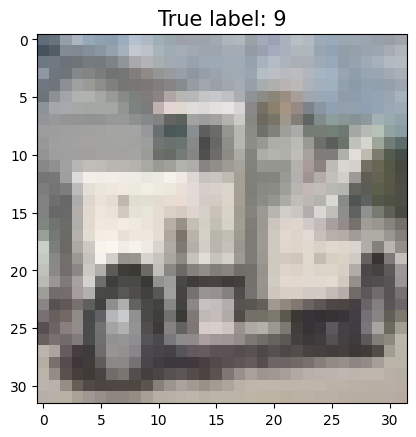

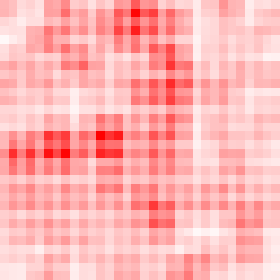

In [111]:
xpl = torch.load('../explanations/CIFAR/std/dualview_0.1/DualViewExplainer_00', map_location=torch.device('cpu'))

test_sample = test[6]
img_test_sample = torch.clip(test.inverse_transform(test_sample[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {test_sample[1]}", fontsize=15)
plt.imshow(img_test_sample.permute(1, 2, 0))
plt.show()

canonizer = SequentialMergeBatchNorm()
composite = EpsilonPlusFlat(canonizers=[canonizer])
mode = "train"

with torch.no_grad():
    train_features = model.features(train_sample[0].unsqueeze(dim = 0))
    test_features = model.features(test_sample[0].unsqueeze(dim = 0))
    attr_output = test_features if mode == "train" else train_features

with Gradient(model=model.features, composite=composite) as attributor:
    out, tda_relevance = attributor(train_sample[0].unsqueeze(dim=0), attr_output)

tda_relevance = tda_relevance[0].sum(0).detach().cpu()

img = imgify(tda_relevance, cmap='bwr', symmetric = True)
img = img.resize((28 * 10, 28 * 10))
display(img)

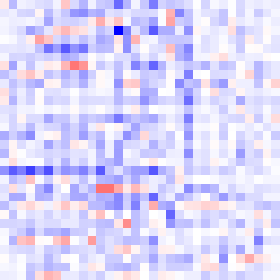

In [112]:
norm_relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min())
norm_tda_relevance = (tda_relevance - tda_relevance.min()) / (tda_relevance.max() - tda_relevance.min())
norm_diff = norm_relevance - norm_tda_relevance

img = imgify(norm_diff, cmap='bwr', symmetric = True)
img = img.resize((28 * 10, 28 * 10))
display(img)

In [ ]:
norm_diff.max(), norm_diff.min()

(tensor(0.0606), tensor(-0.0921))

In [118]:
# Modified version that looks nicer

import matplotlib.patches as patches

nrows = 5
test_idx = 1
most_relevant = True

def add_black_frame(ax):
    """ Adds a black square frame around each subplot """
    rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

def compare_lrp_to_tda_lrp_test_col(test_idx, nrows=10, most_relevant=True, composite=EpsilonPlus()):
    test_sample = test[test_idx]
    train_indices = torch.topk(xpl[test_idx], nrows).indices if most_relevant else torch.topk(-xpl[test_idx], nrows).indices

    # Adjust figure size and spacing for aesthetics
    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(12, 15))
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    # Turn off axis for all subplots for cleaner visuals
    for ax in axes.flatten():
        ax.axis('off')

    # Column 1: Test image (first row only)
    axes[0, 0].imshow(display_img(test_sample, test).permute(1,2,0), interpolation='nearest')
    axes[0, 0].set_title("Test Sample", fontsize=12)
    add_black_frame(axes[0, 0])

    # Column 2: Test image LRP (first row only)
    axes[0, 1].imshow(display_lrp(test_sample, model, composite=composite))
    axes[0, 1].set_title("LRP for Test Sample", fontsize=12)
    add_black_frame(axes[0, 1])

    # Column 3: Test image DuaLRP for different train points (all rows)
    for i in range(nrows):
        axes[i,2].imshow(display_tda_lrp(train[train_indices[i]], test_sample, train_indices[i], test_idx, xpl, model, mode = "test", composite = composite))
        add_black_frame(axes[i, 2])
    axes[0, 2].set_title("DuaLRP for\nTest Sample", fontsize=12)

    # Column 4: Training images (all rows)
    for i in range(nrows):
        axes[i, 3].imshow(display_img(train[train_indices[i]], test).permute(1,2,0), interpolation='nearest')
        add_black_frame(axes[i, 3])
    axes[0, 3].set_title("Train Samples", fontsize=12)

    # Conditional title based on `most_relevant`
    title_relevance = "most positively relevant" if most_relevant else "most negatively relevant"
    plt.suptitle(f"Comparing LRP to DuaLRP\nfor prediction of class '{test_sample[1]}'\nfor the {title_relevance} training points", 
                 fontsize=24, weight='bold', y=1.02)

    plt.show()


def compare_lrp_to_tda_lrp_train_col(test_idx, nrows=10, most_relevant=True, composite=EpsilonPlus()):
    test_sample = test[test_idx]
    train_indices = torch.topk(xpl[test_idx], nrows).indices if most_relevant else torch.topk(-xpl[test_idx], nrows).indices

    # Adjust figure size and spacing for aesthetics
    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(12, 15))
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    # Turn off axis for all subplots for cleaner visuals
    for ax in axes.flatten():
        ax.axis('off')

    # Column 1: Test image (first row only)
    axes[0, 0].imshow(display_img(test_sample, test).permute(1,2,0), interpolation='nearest')
    axes[0, 0].set_title("Test Sample", fontsize=12)
    add_black_frame(axes[0, 0])

    # Column 2: LRP for training samples (all rows)
    for i in range(nrows):
        axes[i, 1].imshow(display_lrp(train[train_indices[i]], model, composite=composite))
        add_black_frame(axes[i, 1])
    axes[0, 1].set_title("LRP for\nTrain Samples", fontsize=12)

    # Column 3: Test image DuaLRP for different train points (all rows)
    for i in range(nrows):
        axes[i,2].imshow(display_tda_lrp(train[train_indices[i]], test_sample, train_indices[i], test_idx, xpl, model, mode = "train", composite = composite))
        add_black_frame(axes[i, 2])
    axes[0, 2].set_title("DuaLRP for\nTrain Samples", fontsize=12)

    # Column 4: Training images (all rows)
    for i in range(nrows):
        axes[i, 3].imshow(display_img(train[train_indices[i]], test).permute(1,2,0), interpolation='nearest')
        add_black_frame(axes[i, 3])
    axes[0, 3].set_title("Train Samples", fontsize=12)

    # Conditional title based on `most_relevant`
    title_relevance = "most positively relevant" if most_relevant else "most negatively relevant"
    plt.suptitle(f"Comparing LRP to DuaLRP\nfor prediction of class '{test_sample[1]}'\nfor the {title_relevance} training points", 
                 fontsize=24, weight='bold', y=1.02)

    plt.show()


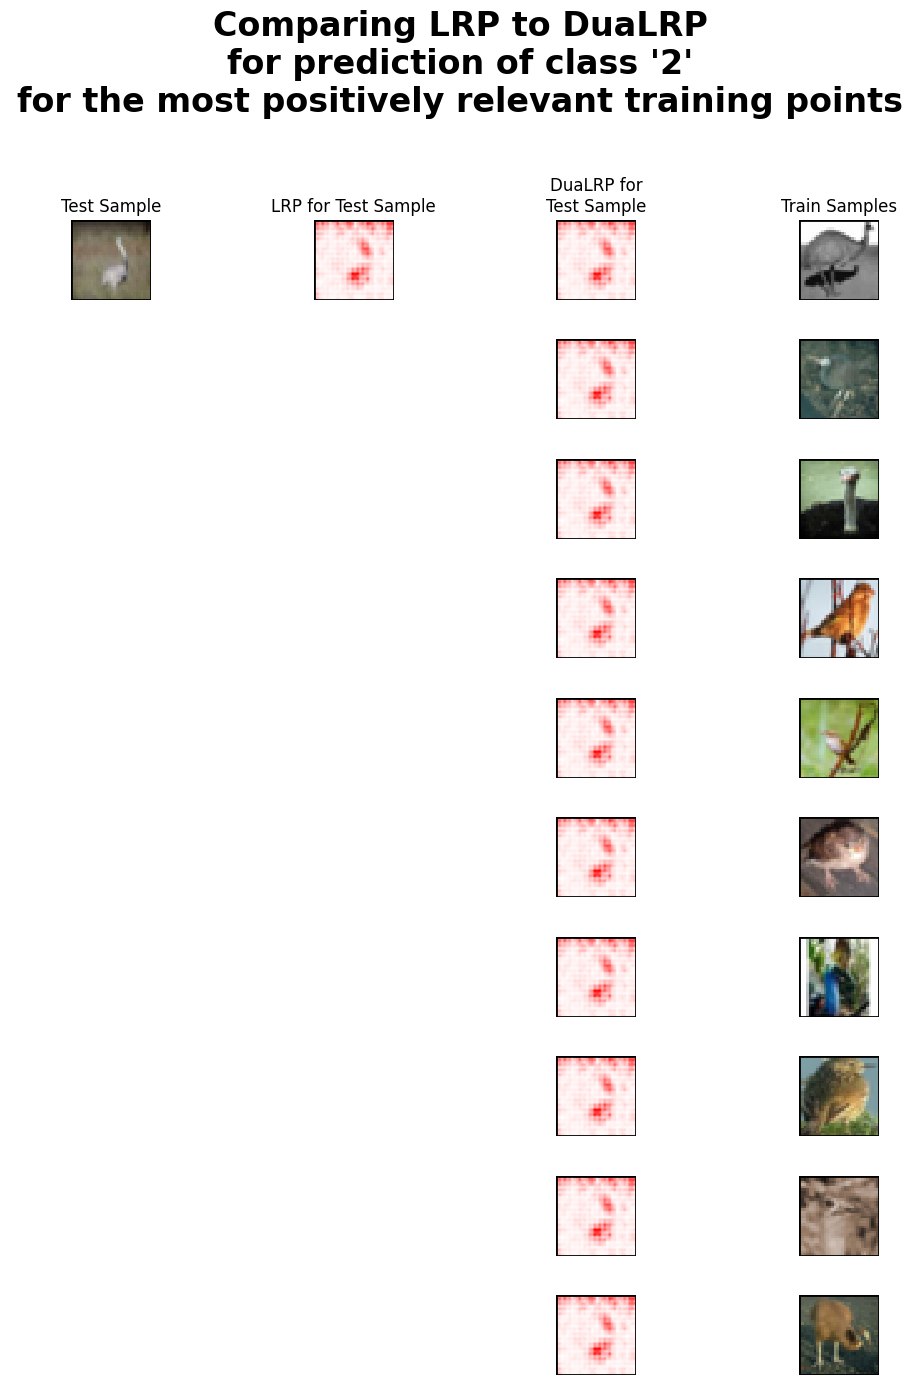

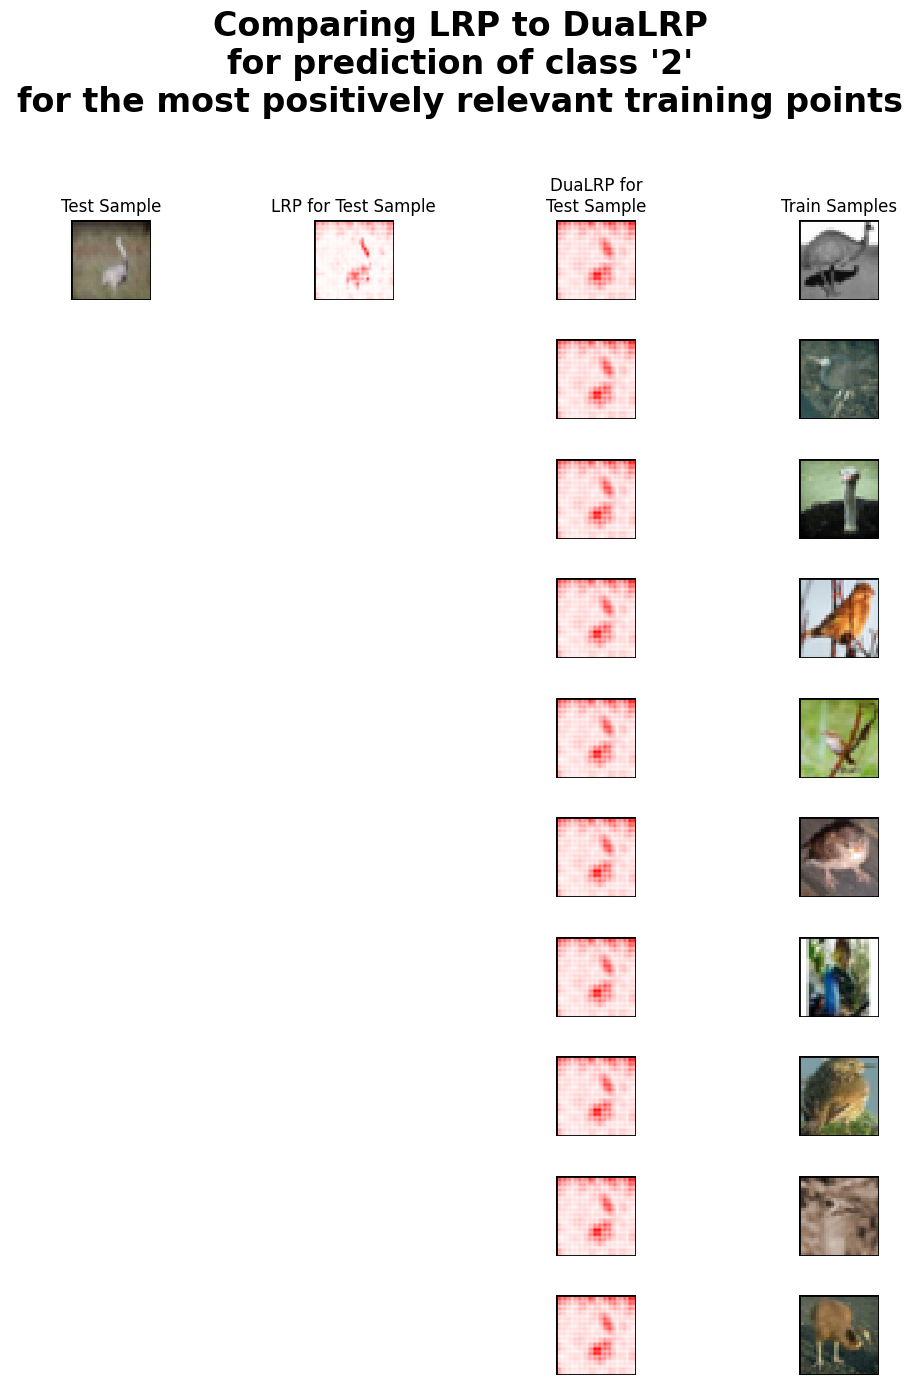

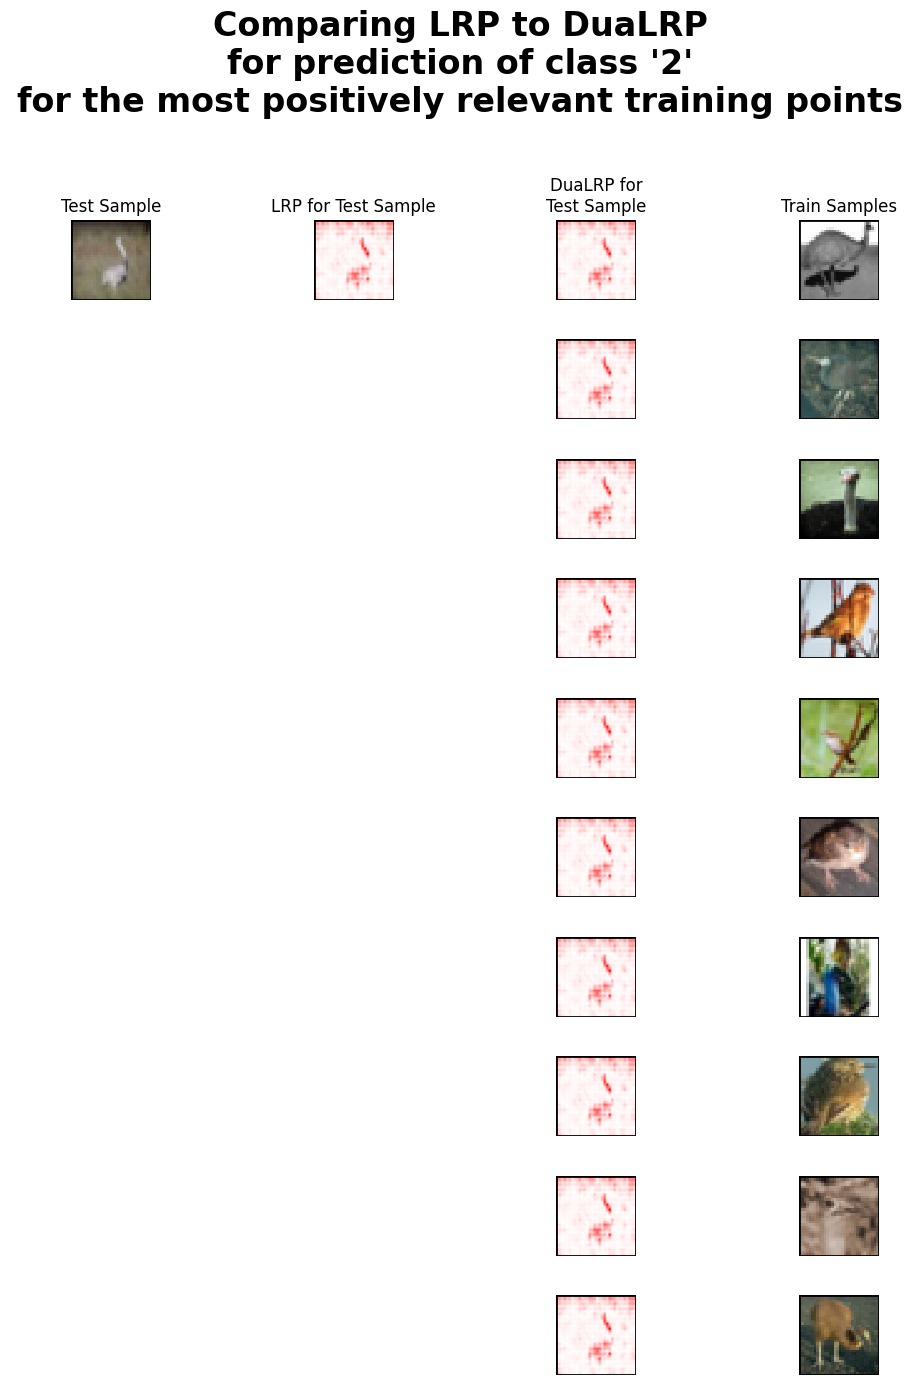

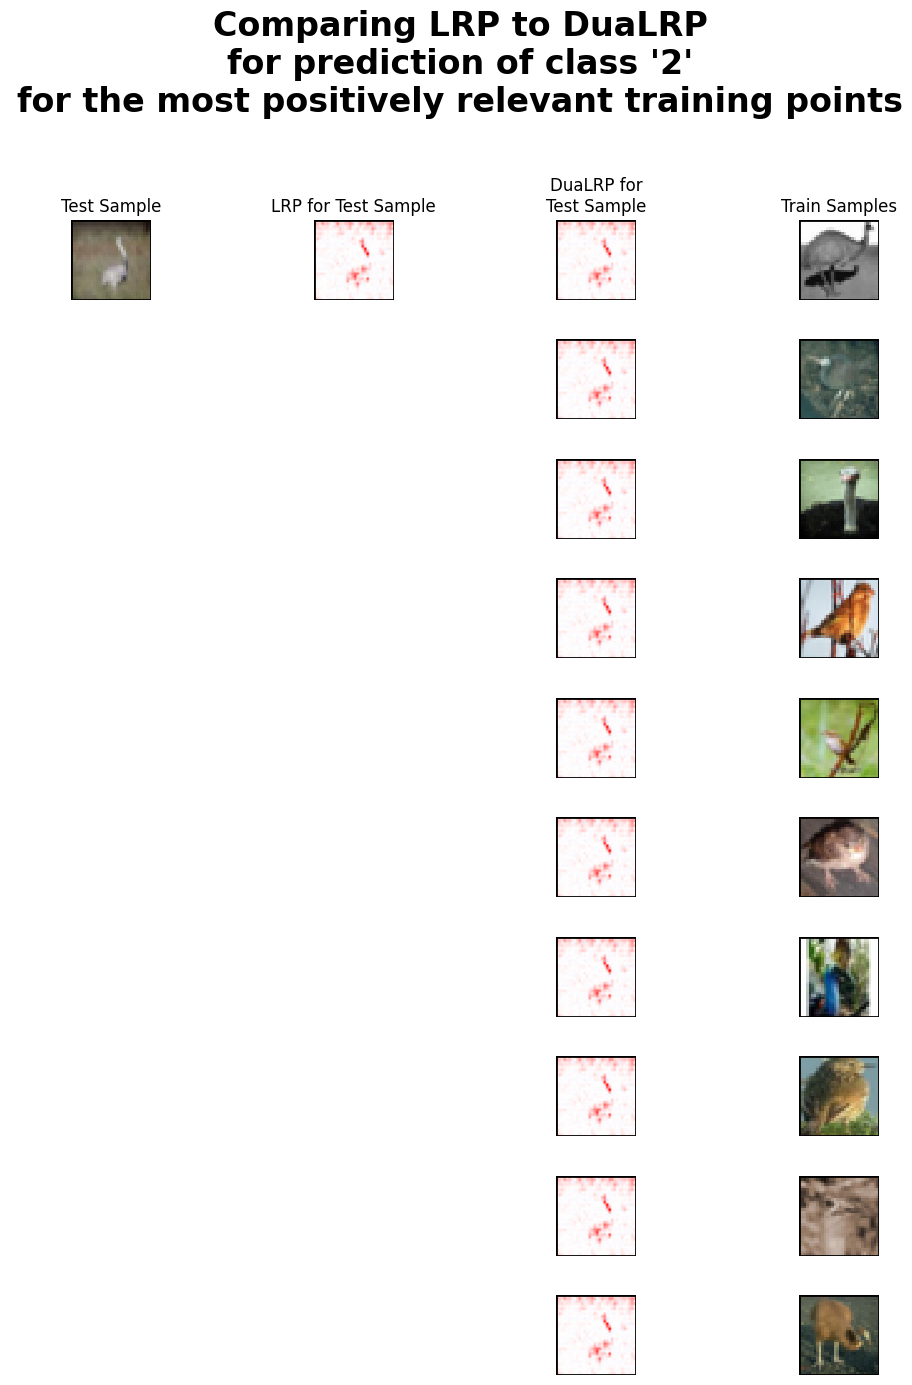

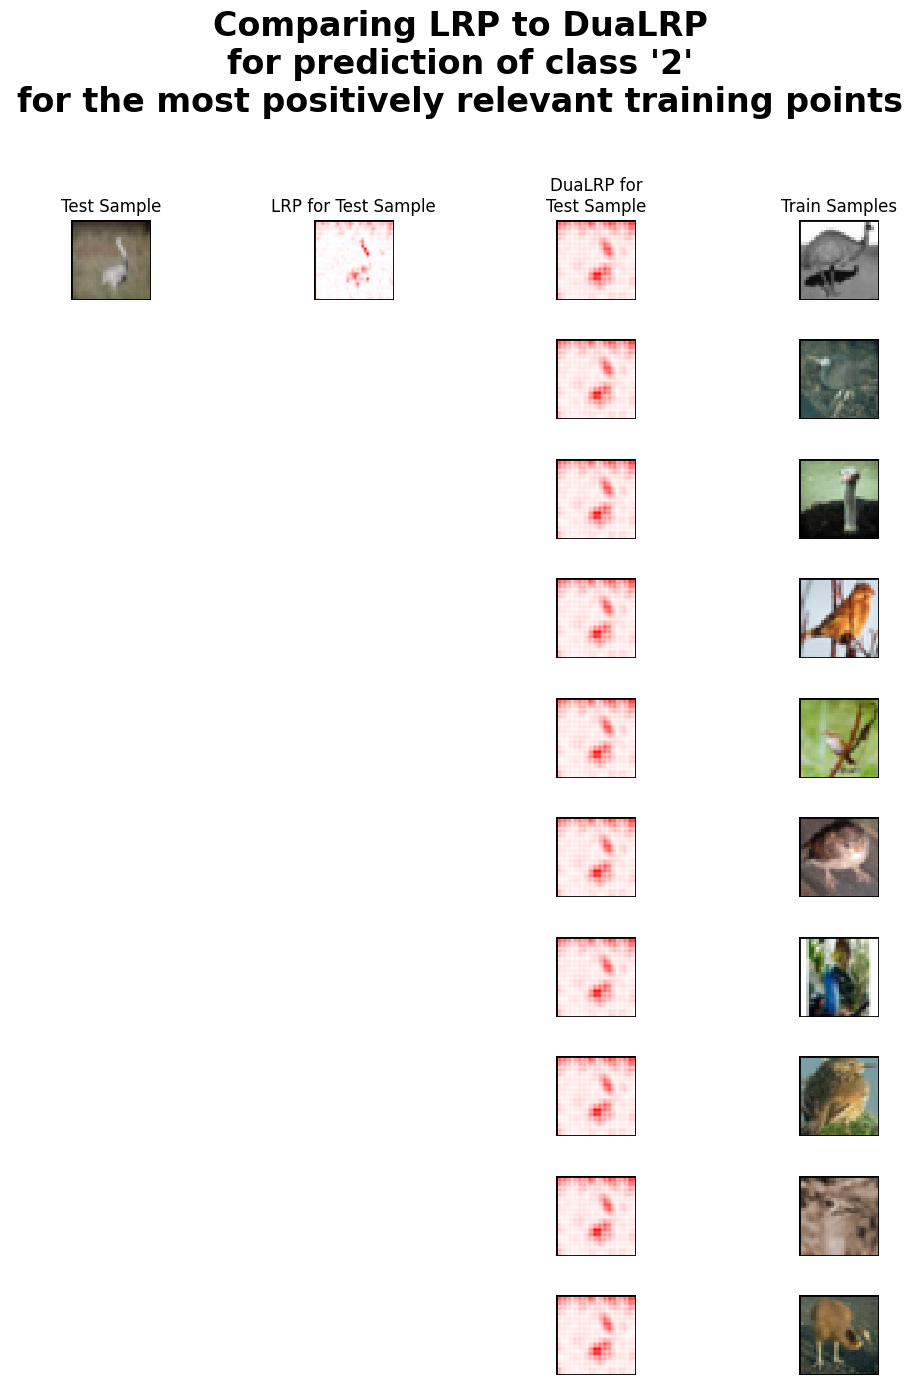

In [119]:
test_idx=0
low, high = torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]])

canonizer = SequentialMergeBatchNorm()
composite = EpsilonGammaBox(low=sample_min, high=sample_max, canonizers=[canonizer])
compare_lrp_to_tda_lrp_test_col(test_idx, nrows=10, most_relevant=True, composite=composite)

for composite in [EpsilonPlusFlat, EpsilonPlus, EpsilonAlpha2Beta1, EpsilonAlpha2Beta1Flat]:
    composite = composite(canonizers=[canonizer])

    compare_lrp_to_tda_lrp_test_col(test_idx, nrows=10, most_relevant=True, composite=composite)

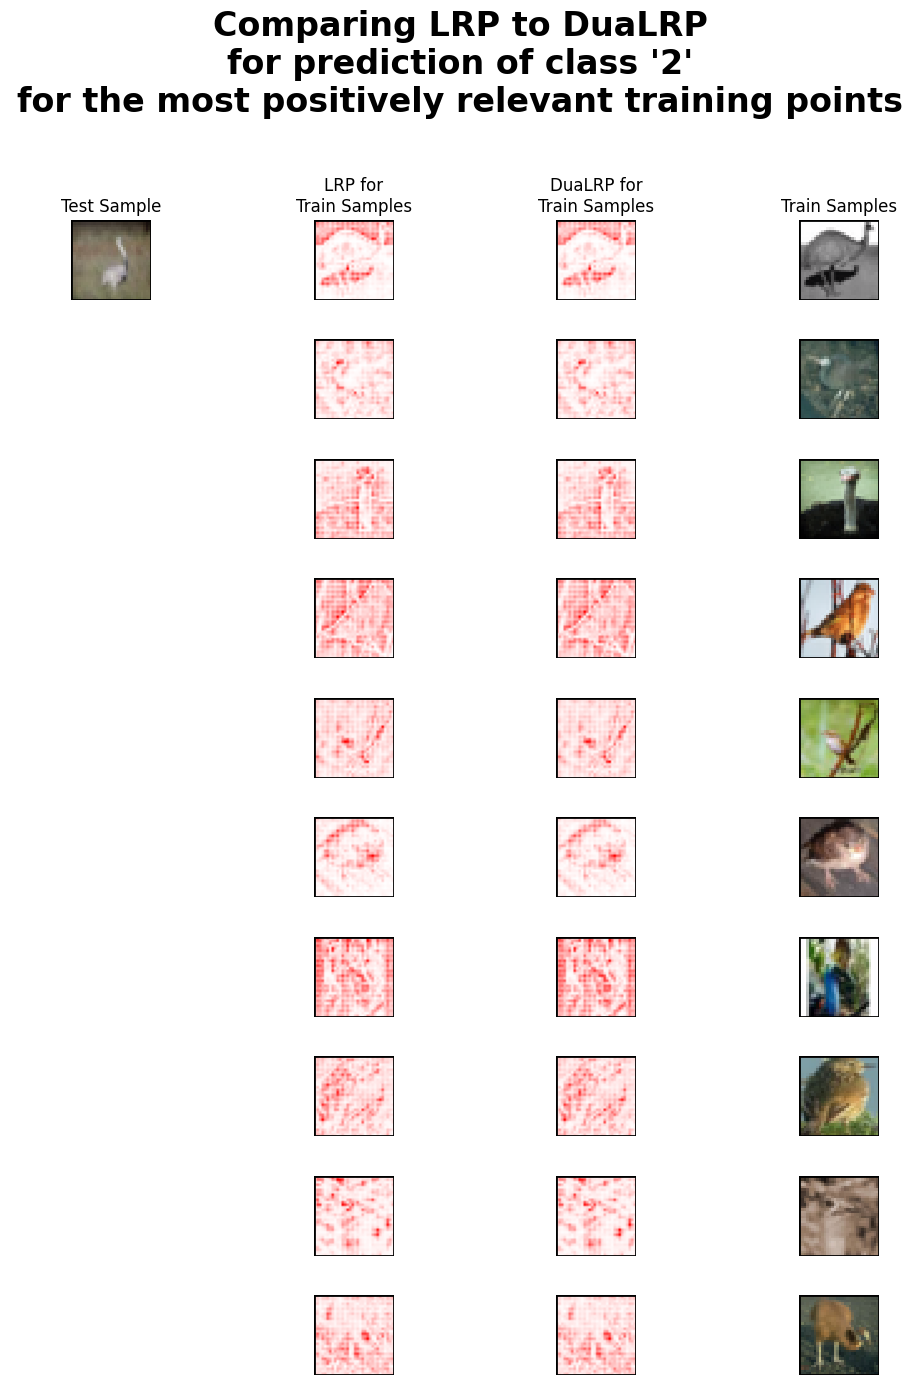

In [120]:
compare_lrp_to_tda_lrp_train_col(test_idx, nrows=10, most_relevant=True, composite=EpsilonPlus())

# Add concepts 

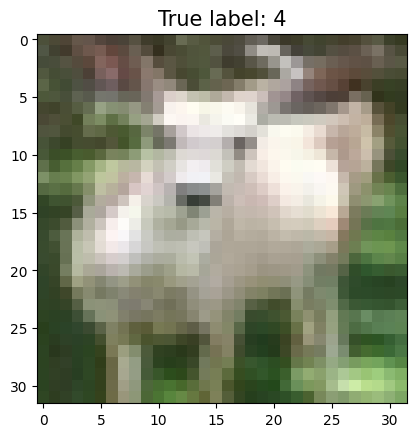

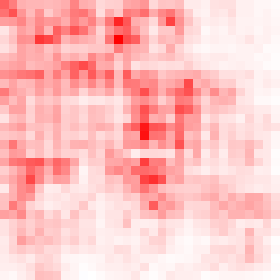

In [ ]:
test_sample = test[2]
img_test_sample = torch.clip(test.inverse_transform(test_sample[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {test_sample[1]}", fontsize=15)
plt.imshow(img_test_sample.permute(1, 2, 0))
plt.show()

composite = EpsilonGammaBox(low=-3., high=3.)
mode = "train"

with torch.no_grad():
    train_features = model.features(train_sample[0].unsqueeze(dim = 0))
    test_features = model.features(test_sample[0].unsqueeze(dim = 0))
    attr_output = test_features if mode == "train" else train_features
    #attr_output = attr_output * torch.eye(attr_output.shape[1])[[405]]

with Gradient(model=model.features, composite=composite) as attributor:
    out, tda_relevance = attributor(train_sample[0].unsqueeze(dim=0), attr_output)

tda_relevance = tda_relevance[0].sum(0).detach().cpu()

img = imgify(tda_relevance, cmap='bwr', symmetric = True)
img = img.resize((28 * 10, 28 * 10))
display(img)

## Conjoint experiment with CIFAR

In [ ]:
class_idx_dict_cifar = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    4 : [],
    5 : [],
    6 : [],
    7 : [],
    8 : [],
    9 : [],
}

for i in range(len(train)):
    class_idx_dict_cifar[int(train[i][1])].append(i)

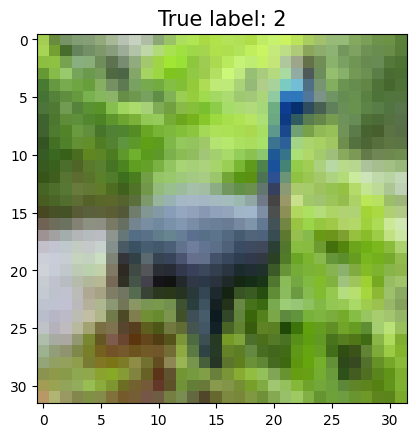

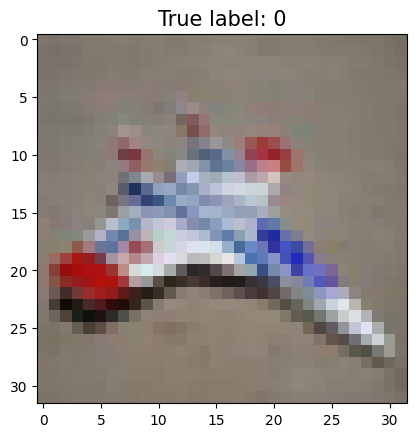

In [ ]:
train_sample_0 = train[class_idx_dict_cifar[2][0]]
img_train_sample = torch.clip(train.inverse_transform(train_sample_0[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {train_sample_0[1]}", fontsize=15)
plt.imshow(img_train_sample.permute(1, 2, 0))
plt.show()

train_sample_1 = train[class_idx_dict_cifar[0][1]]
img_train_sample = torch.clip(train.inverse_transform(train_sample_1[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {train_sample_1[1]}", fontsize=15)
plt.imshow(img_train_sample.permute(1, 2, 0))
plt.show()

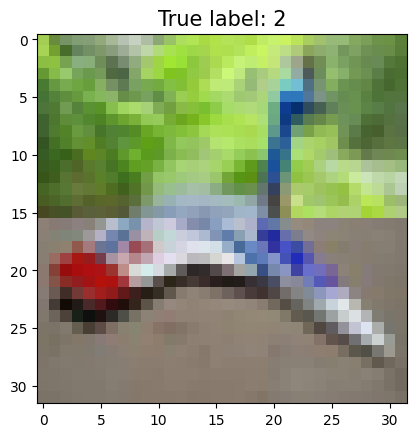

In [ ]:
train_conjoint = (torch.empty((3,32,32)), train_sample_0[1])
train_conjoint[0][:,:16,:] = train_sample_0[0][:,:16,:]
train_conjoint[0][:,16:,:] = train_sample_1[0][:,16:,:]

img_train_sample = torch.clip(train.inverse_transform(train_conjoint[0].clone().detach()), min=0., max=1.).squeeze()

plt.title(f"True label: {train_conjoint[1]}", fontsize=15)
plt.imshow(img_train_sample.permute(1, 2, 0))
plt.show()

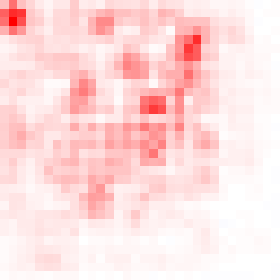

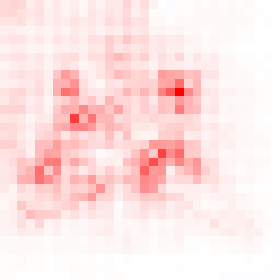

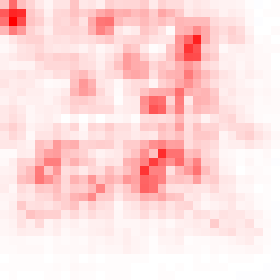

In [ ]:
display_lrp(train_sample_0, model, train_sample_0[1])
display_lrp(train_sample_1, model, train_sample_0[1])
display_lrp(train_conjoint, model, train_sample_0[1])

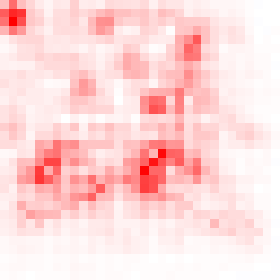

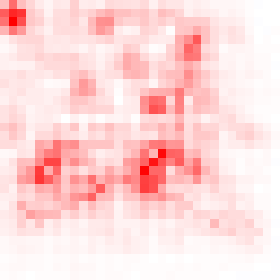

In [ ]:
display_tda_lrp(train_conjoint, train_sample_0, model, train_sample_0[1])
display_tda_lrp(train_conjoint, train_sample_1, model, train_sample_0[1])

# Try with AwA

In [ ]:
dualview_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_root = f"{dualview_root}/src/datasets"
class_groups = None
validation_size=2000
num_classes=50
device = "cpu"
dataset_name = "AWA"
dataset_type = "std"
model_path = f"{dualview_root}/checkpoints/AWA/std/resnet50_std/AWA_resnet50"
model_name = "resnet"

ds_kwargs = {
    'data_root': data_root,
    'class_groups': class_groups,
    'image_set': "test",
    'validation_size': validation_size,
    'only_train': False,
    'transform': None
}

train, test = load_datasets(dataset_name, dataset_type, **ds_kwargs)
model = load_awa_model(model_path, dataset_type, num_classes, device)
#checkpoint = torch.load(model_path, map_location=device)
#model.load_state_dict(checkpoint["model_state"])
model.to(device)
model.eval()
print('\n')
print(model)

Validation ids:
tensor([4110, 6869, 1478,  ..., 3026, 6516, 2245])
Test ids:
tensor([1946, 1647, 4547,  ...,  461, 5527, 4213])


c:\Users\weckbecker\DualView-wip\src\datasets\AWA.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_ids = torch.tensor(perm[:validation_size].clone().detach())
c:\Users\weckbecker\DualView-wip\src\datasets\AWA.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.test_ids = torch.tensor(perm[validation_size:].clone().detach())


FileNotFoundError: [Errno 2] No such file or directory: '../../mnt/checkpoints/AWA/std/resnet_std/AWA_resnet'